In [1]:
from random import randint
import pandas as pd
import numpy as np
import random
import re

import nltk
from nltk.corpus import stopwords , gutenberg
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from sklearn.model_selection import GridSearchCV , RandomizedSearchCV
from sklearn.feature_extraction.text import TfidfTransformer , CountVectorizer , TfidfVectorizer
from sklearn.metrics import homogeneity_score, cohen_kappa_score, silhouette_score, silhouette_samples
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix , accuracy_score
from sklearn.utils import shuffle
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from six.moves import urllib
import seaborn as sns
from scipy.spatial.distance import pdist

In [2]:
!pip install --upgrade plotly

     |████████████████████████████████| 23.9 MB 14 kB/s 
  Attempting uninstall: plotly
    Found existing installation: plotly 4.4.1
    Uninstalling plotly-4.4.1:
      Successfully uninstalled plotly-4.4.1


In [3]:
import plotly.express as px

In [4]:
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('universal_tagset')
nltk.download('stopwords')
nltk.download('vader_lexicon')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package universal_tagset to /root/nltk_data...
[nltk_data]   Unzipping taggers/universal_tagset.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

In [5]:
# !wget 'https://nlp.stanford.edu/software/stanford-ner-2018-10-16.zip'
# !unzip stanford-ner-2018-10-16.zip

**Text**

In [6]:
!pip install textstat

     |████████████████████████████████| 101 kB 10.7 MB/s 
     |████████████████████████████████| 2.0 MB 59.0 MB/s 


In [7]:
from nltk.tag import StanfordNERTagger
import spacy
from collections import Counter
import string
import textstat
from nltk.sentiment.vader import SentimentIntensityAnalyzer

NER = spacy.load("en_core_web_sm")

def get_polarity(text):
  return analyzer.polarity_scores(text)["compound"]

def extractText(book):
    '''
    Performs cleaning on the text. Most
    books start and end with a  certain
    pattern, so the  text in the middle
    is extracted.
    '''
    text_start_pattern = re.compile("\*\*\*\s*start.*?\*\*\*", re.IGNORECASE)
    text_end_pattern = re.compile("\*\*\*(\s)*end(.)*\*\*\*", re.IGNORECASE)
    
    start_match = text_start_pattern.search(book)
    end_match = text_end_pattern.search(book)
    
    if(start_match is not None):
        book = book[start_match.end():]
        
    if(end_match is not None):
        book = book[:end_match.start()]
        
    return book

def joinDocPartitions(text_df, groupby_col="book_name", EOP_token=None):
    doc_labels = sorted(text_df[groupby_col].unique())
    docs = []
    for i, label in enumerate(doc_labels):
        doc_text = text_df[text_df[groupby_col] == label]
        if(EOP_token):
            doc_text = doc_text.apply(lambda x: x + EOP_token)
        text = ' '.join(doc_text["partition"].values)
        docs.append(text)
    return docs


def extractPersonNames(text):
    persons = []
    st = StanfordNERTagger('/content/stanford-ner-2018-10-16/classifiers/english.all.3class.distsim.crf.ser.gz',
                       '/content/stanford-ner-2018-10-16/stanford-ner.jar', encoding='utf-8')
    tokenized_text = nltk.word_tokenize(text)
    tags = st.tag(tokenized_text)
    for tag in tags:
        if tag[1] == 'PERSON':
            persons.append(tag[0].lower())
    return list(set(persons))

def countNamedEntities(df_row):
  text = NER(df_row.partition)
  entity_counts = dict(Counter(word.label_ for word in text.ents))
  for key, val in entity_counts.items():
        df_row[key] = val
  return df_row


def countPunctuation(text):
    punctuation = ['.', '?', '!', ',', ':', ';', '-', 
                   '[', ']', '(', ')', '{', '}', '\'',
                   '\"']
    c = Counter(text)
    count_punct = 0
    for p in punctuation:
        count_punct += c[p]
    return count_punct

def CountPOSTag(df_row):
    words = nltk.word_tokenize(df_row.partition)
    tagged_text = nltk.pos_tag(words, tagset='universal')
    POS_tag_count = dict(Counter(p[1] for p in tagged_text if p[0] not in string.punctuation))
    for key, val in POS_tag_count.items():
        df_row[key] = val
    return df_row

def extractFeatures(df):
    df_features = df.copy()
    df_features["Punct_count"] = df_features["partition"].apply(countPunctuation)
    df_features["Word_count"] = df_features["partition"].apply(lambda x: len([w for w in nltk.word_tokenize(x) 
                                                                         if w not in string.punctuation]))
    df_features['Char_count'] = df_features["partition"].apply(lambda x: sum(len(w) for w in nltk.word_tokenize(x) 
                                                                        if w not in string.punctuation))
    df_features['Avg_word_length'] = df_features['Char_count'] / df_features['Word_count']
    df_features = df_features.apply(CountPOSTag, axis=1)

    df_features = df_features.apply(countNamedEntities, axis=1)
    df_features.fillna(0, inplace=True)
    #df_features['partition'], df_features['book_name'] = df_features.pop('partition'), df_features.pop('book_name')
    return df_features


def plotFeatures(df, feature_cols, target_col, figsize):
    fig, axs = plt.subplots(nrows=len(feature_cols), figsize=figsize)
    for i, col in enumerate(feature_cols):
        sns.kdeplot(x=col, hue=target_col, data=df, ax=axs[i], fill=True, palette='bright')

def cleanText(text, remove_words=[]):
    '''Tokenize, stem, and remove
    stopwords along with any other
    required words.
    
    Parameters:
        text(str): Text to be cleaned
    
    Returns:
        text_cleaned(str): Text after cleaning.
    ''' 
    tokenized_words = nltk.word_tokenize(text)

    ps = PorterStemmer()
    stop_words = set(stopwords.words("english") + remove_words)
    
    text_cleaned = [ps.stem(w.lower()) for w in tokenized_words
                    if w.lower() not in stop_words]
    
    text_cleaned = ' '.join(text_cleaned)
    
    # remove special chars
    text_cleaned = re.sub('[^a-zA-Z]', ' ', text_cleaned)
    
    return text_cleaned 

def sampleText(text, n_samples, partition_size, label):
    '''
    Takes random samples from the text. Appending to DataFrames
    is expensive, therefore this returns a list
    of samples that could later be used to create
    a DataFrame.

    Parameters:
        text(str): text to be sampled from.
        n_samples(int): number of samples to be drawn from text.
        sample_len(int): length, in words, of each sample.
        label(str): label to be added to samples from each book.
        
    Returns:
        samples(list): list of tuples containing samples and labels.
    '''
    book_len = len(text.split())
    text_split = text.split()
    partitions = [(' '.join(text_split[i:i+partition_size]), label) 
                  for i in range(0, len(text_split), partition_size)]

    samples = random.sample(partitions, n_samples)
    return samples

def readBook(book_url, encoding='utf-8'):
    '''
    Reads a book from url
    '''
    book = urllib.request.urlopen(book_url).read().decode(encoding)
    return book

/usr/local/lib/python3.7/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


### **Most Freq words in all clusters**

In [8]:
"""
  - get n_Top Freq words in all clusters
  - get existance of each word in each cluster
  - return DataFrame of columns : most freq words , row : represent each cluster and the existance of each word inside it
"""
def mostFreqWords_valuePerCluster(df, groupby_col, outColumns, n_Top):

  newdf = df.copy().drop(outColumns, inplace=False, axis=1)   #drop book_name Col

  # string col names as DOC2Vec colnames are numbers and can't bre compared with string "groupby_col"
  newdf.columns = newdf.columns.astype(str)

  #make dict with column names and the operation that will apply on each one
  agg_dict = dict.fromkeys(np.setdiff1d(newdf.columns,[groupby_col]) , 'sum') 
  
  # group by centroid column and sum the values
  sum_df = newdf.groupby(groupby_col).agg(agg_dict).reset_index() 

  # sum values of all clusters to get most n_top freq words in all clusters
  sum_row = sum_df.iloc[:,1:].sum()  

  freq = sum_row.nlargest(n_Top).values # get top freq values
  words = sum_row.nlargest(n_Top).index  #get words

  cols = words.to_list()
  cols.append(groupby_col)

  return sum_df[cols]

def plot_parrallelCoordinates(df , groupby_col , outColumns , n_Top):
   
  mostFreq_df = mostFreqWords_valuePerCluster(df,groupby_col , outColumns , n_Top)
  \
  #parrallel coordinates
  with plt.style.context(("ggplot", "seaborn")):
    fig = plt.figure(figsize=(10,6))
   
    # pd.plotting.parallel_coordinates(mostFreq_df, class_column=groupby_col,
    #                                  alpha=1, colormap="gist_rainbow")
    
    fig = px.parallel_coordinates(mostFreq_df.to_dict('list'), 
                                     color = groupby_col,
                                     color_continuous_scale=px.colors.diverging.Tealrose,
                                    color_continuous_midpoint=2)

    fig.show()

def plot_word_freq_cluster(word_freqs):
  vals = [list(word_freqs[i].itertuples(index=False, name=None))
           for i in range(len(word_freqs))]
  n_clusters = len(word_freqs)
  all_words = [vals[j][i][0] for i in range(len(vals[0])) for j in range(len(vals))]
  all_word_counts = [vals[j][i][1] for i in range(len(vals[0])) for j in range(len(vals))]
  

  fig, ax = plt.subplots(figsize=(15, 10))
  offset = np.zeros(n_clusters)
  cm = plt.get_cmap('Blues_r', 10)

  for i in range(len(vals[0])):
    words = []
    counts = []
    for j in range(len(vals)):
      words.append(vals[j][i][0])
      counts.append(vals[j][i][1])
    ax.barh(range(n_clusters), counts, left=offset, color=cm(i))
    offset += counts

  offset_x = np.zeros(n_clusters) 
  for idx, a in enumerate(ax.patches):
    fc = 'k' if sum(a.get_fc()) > 2.5 else 'w'
    ax.text(offset_x[idx%n_clusters] + a.get_width()/2, a.get_y() + a.get_height()/2, 
            '{}\n{:.2f}'.format(str(all_words[idx])[:6], all_word_counts[idx]), 
            ha='center', va='center', color=fc, fontsize=14, family='monospace')
    offset_x[idx%n_clusters] += a.get_width()


  ax.set_title('Most common words in each cluster')
  ax.set_xlabel('Word Frequency')
  ax.set_ylabel('Clusters')

  plt.tight_layout()
  plt.show()
      
  ax.set_yticklabels(range(n_clusters))
  ax.invert_yaxis()


### **plot knowledge graph**

In [9]:
import matplotlib.pyplot as plt
import networkx as nx
import networkx as nx

def knowledgeGraph(dataframe ,
                   n_top = 100 ,
                   groupby = "book_name",
                   no_outsumcols = 1,
                   shared_only = True,
                   degree_threshold = 3,
                   max_width = 12,
                   node_size_amplifier = 200,
                   k = 2,
                   is_numeric = True,
                   bookName_Col_idx = -1):

  if (is_numeric == False):
    count_vec = CountVectorizer(max_features=1000)
    bow = count_vec.fit_transform(dataframe.iloc[:,:-1*no_outsumcols].partition).toarray()
    vocab = count_vec.get_feature_names()

    bow_df = pd.DataFrame(bow, columns = [v for v in vocab])
    bow_df['book_name'] = dataframe.iloc[:,bookName_Col_idx].values
    dataframe = bow_df.copy()
    
  freq_words_per_doc = getMostFreqWords(dataframe, n_top, groupby ,no_outsumcols = no_outsumcols)

  doc_labels = sorted(dataframe[groupby].unique())

  source = [book_name for book_name in doc_labels for i in range(n_top)] #book names
  target = [word for doc_id in range(len(freq_words_per_doc)) for word in freq_words_per_doc[doc_id].Term]
  relations = [frq for doc_id in range(len(freq_words_per_doc)) for frq in freq_words_per_doc[doc_id].Freq]

  kg_df = pd.DataFrame({'source':source, 'target':target, 'edge':relations})

  # create a directed-graph from a dataframe
  G=nx.from_pandas_edgelist(kg_df, 
                            "source",
                            "target", 
                            edge_attr=True,
                            create_using=nx.MultiDiGraph())

  # degree
  degrees = dict(G.degree)
  shared_words = [k for k,v in degrees.items() if v > degree_threshold ]


  if shared_only == True:
    # Let's filter to get only shared words
    filter = kg_df['target'].apply(lambda x:x in shared_words)

    # new Graph
    G = nx.from_pandas_edgelist(kg_df[filter], "source", "target", 
                            edge_attr=True, create_using=nx.MultiDiGraph())
    
    # degree 
    degrees = dict(G.degree)


  # Normalized freq (width was very large so I normalize)
  words_freq = [w for (*edge , w) in G.edges.data('edge')]

  norm = np. linalg. norm(words_freq)
  normalized_words_freq = (words_freq/norm)*max_width

  plt.figure(figsize=(12,12))
  pos = nx.spring_layout(G,k = k)

  nx.draw(G,
          node_size = [v * node_size_amplifier for v in degrees.values()],
          width = normalized_words_freq,
          #width = 4,
          # edge_color = normalized_words_freq,
          node_color='skyblue',
          with_labels = True,
          cmap=plt.get_cmap('viridis'),
          edge_cmap=plt.cm.Blues,
          pos = pos)

  plt.show()

### **Most Freq word per Doc or Cluster**

In [10]:
def getMostFreqWordsPerDoc(freq_df, top_n, label, groupby_col,no_outsumcols):
    label_rows = freq_df[freq_df[groupby_col] == label].iloc[:, :-1*no_outsumcols]
    sum_row = label_rows.sum()
    
    freq = sum_row.nlargest(top_n).values
    words = sum_row.nlargest(top_n).index
    
    return words, freq

def getMostFreqWords(freq_df, top_n,groupby_col,no_outsumcols):
    doc_labels = sorted(freq_df[groupby_col].unique())
    freq_dfs = []
    
    for label in doc_labels:
        words, freq = getMostFreqWordsPerDoc(freq_df, top_n, label,groupby_col,no_outsumcols)
        
        df = pd.DataFrame(zip(words, freq), columns = ["Term", "Freq"])
        freq_dfs.append(df)

    return freq_dfs

def plotMostFreqWords(freq_dfs, top_n):
    for i, df in enumerate(freq_dfs):
        freq_words = df.iloc[:top_n, :]
        freq_words.plot(x="Term", y="Freq", kind="barh", title=f"Most Freq Terms in Book {i}")
        plt.savefig(f"BOW_res{i}.png", dpi=150, bbox_inches='tight')


def getMostFreqWordsText(text_df, n_words, groupby_col):
  '''Accepts df with text partitions unlinke
      getMostFreqWords function that needs
      BOW or TFIDF encoded df'''
  docs = joinDocPartitions(text_df, groupby_col)
  freq_terms = []
  for doc in docs:
    vectorizer = CountVectorizer(max_features=n_words)
    vectorizer.fit([doc])
    vocab = vectorizer.get_feature_names()
    freq_terms.append(vocab)
  return freq_terms

def dropFreqWords(df, n_words, is_numeric=True, groupby_col='book_name'):
  '''Drops n most frequent words from each
    book'''
  clean_df = df.copy()
  if(is_numeric):
    freq_words_per_doc = getMostFreqWords(clean_df, n_words, groupby_col, 1)
    freq_terms = [term for df in freq_words_per_doc for term in df.Term.values]
    clean_df.drop(freq_terms, axis = 1, inplace=True)
  else:
    freq_terms = getMostFreqWordsText(clean_df, n_words, groupby_col)
    clean_df["partition"] = clean_df["partition"].apply(lambda sent: ' '.join([word for word in sent.split() if word not in freq_terms ]))
  
  return clean_df

In [ ]:
book_urls = [['https://www.gutenberg.org/files/17321/17321-0.txt', 'History'],
        ['https://www.gutenberg.org/cache/epub/22775/pg22775.txt', 'Psychotherapy'],
        ['https://www.gutenberg.org/cache/epub/10136/pg10136.txt', 'Household Management'],
        ['https://www.gutenberg.org/cache/epub/28056/pg28056.txt', 'Music'],
        ['https://www.gutenberg.org/cache/epub/51854/pg51854.txt', 'The Rat Race']]

partition_size = 250
n_samples = 200

# Reading books

In [ ]:
'''We read the books, and sample from them before cleaning to avoid losing important features'''
samples = []
person_names_all_books = []

for url, label in book_urls:
    book = readBook(url)
    text = extractText(book)
    sample = sampleText(text, n_samples, partition_size, label)
    samples.extend(sample)
    sampled_text = ' '.join(a[0] for a in sample)
    #names = extractPersonNames(sampled_text)
    #person_names_all_books.extend(names)

In [ ]:
df = pd.DataFrame(samples,columns=['partition','book_name'])
df

partition     book_name
0    one of the bound captives out to die, wears a ...       History
1    found at the foot of a royal pyramid of this p...       History
2    ancient origin, and if the nomes go back to a ...       History
3    wall from its foundation to its coping stone, ...       History
4    obliterated, just as the older VIth Dynasty ga...       History
..                                                 ...           ...
995  would I be in. Vail, she reported, was still i...  The Rat Race
996  me, in charge of the O.S.S. "until Bill gets b...  The Rat Race
997  quite sorry for the statue down there in front...  The Rat Race
998  into a poker-game. By the time we pulled into ...  The Rat Race
999  I'd need a terrific wing-spread to get off the...  The Rat Race

[1000 rows x 2 columns]

In [ ]:
df.to_csv('books.csv',index = False)

# Reading Data From CSV

In [11]:
df = pd.read_csv('books.csv')

In [12]:
df

partition     book_name
0    Produced by David Widger [Illustration: Book S...       History
1    name in the closing words of his text when he ...       History
2    decorated with dragons shooting out their tong...       History
3    not already possess complete specimens of this...       History
4    the preservative salts it contains, not to int...       History
..                                                 ...           ...
995  for my signature and the doctor thrust a fount...  The Rat Race
996  there is to our story." "Poor Jimmie!" I sympa...  The Rat Race
997  parted sleekly in the 1860 style, and a cool, ...  The Rat Race
998  to her and sniffed the sharp perfume of desire...  The Rat Race
999  you is that the Germans had no part in it. Onl...  The Rat Race

[1000 rows x 2 columns]

# Extract Raw Features and Visualize

In [13]:
analyzer = SentimentIntensityAnalyzer()

df_features = extractFeatures(df)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)


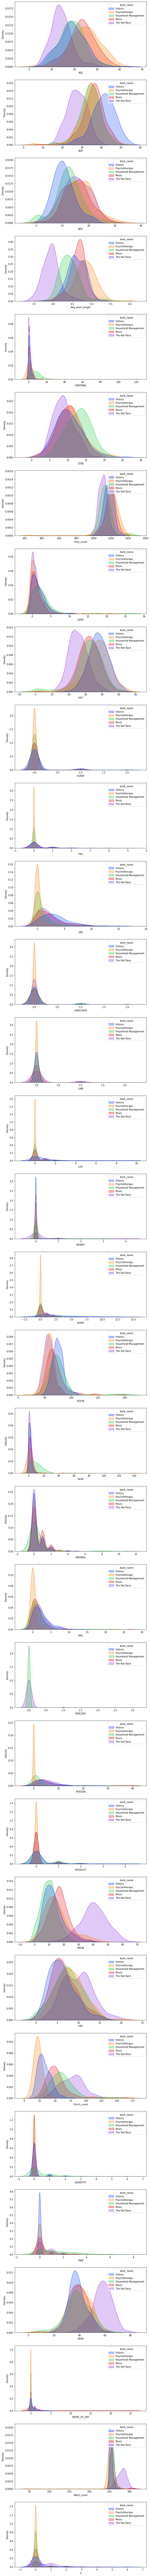

In [14]:
plotFeatures(df_features, df_features.columns[1:-2], 'book_name', (10, 200))

In [15]:
df_features["polarity"] = df_features["partition"].apply(get_polarity)
df_features["dale_chall_readability"] = df_features["partition"].apply(textstat.dale_chall_readability_score)
df_features["dale_chall_readability"] = pd.cut(df_features["dale_chall_readability"],
                                                    bins=[0, 4.9, 5.9, 6.9, 7.9, 8.9, 9.9, 100], 
                                                    labels=["-4", "5-6", "7-8", "9-10", "11-12", "college", "graduate"])
    

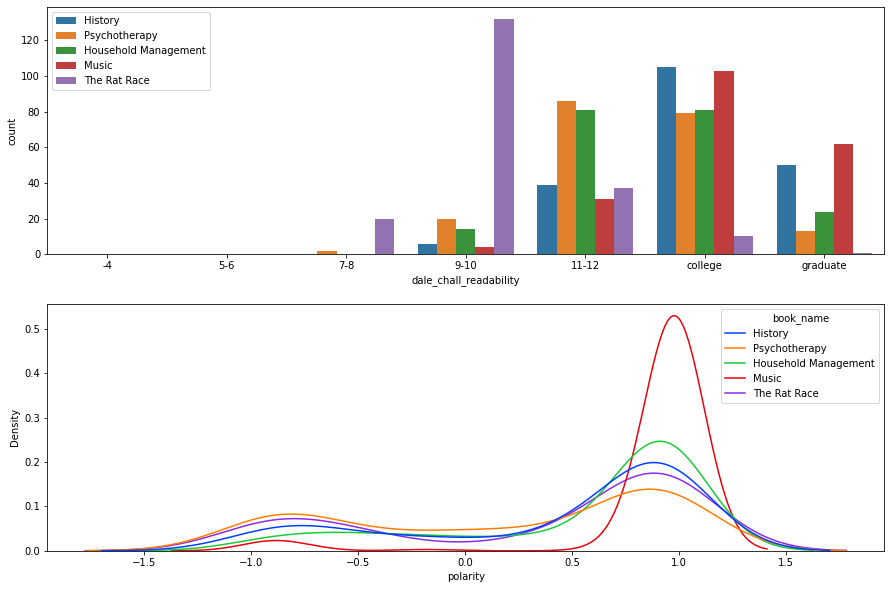

In [16]:
fig, axs = plt.subplots(2, 1, figsize=(15, 10))

sns.countplot(x = "dale_chall_readability",       
              hue = "book_name",  
              ax=axs[0],
              data = df_features)
axs[0].legend(loc='upper left')


sns.kdeplot(x='polarity', hue="book_name", data=df_features, 
            ax=axs[1], palette='bright')

# Clean the Data

In [17]:
df["partition"] = df["partition"].apply(lambda x : cleanText(x))

In [18]:
df.head()

partition book_name
0  produc david widger   illustr   book spine   h...   History
1  name close word text curs goddess destruct sac...   History
2  decor dragon shoot tongu   bolt great door fas...   History
3  alreadi possess complet specimen class tomb   ...   History
4  preserv salt contain   intent embalm   evid in...   History

In [19]:
word_count = df["partition"].apply(lambda x: len(x.split()))
word_count

0      140
1      117
2      123
3      128
4      122
      ... 
995    130
996    130
997    128
998    133
999    124
Name: partition, Length: 1000, dtype: int64

# Data

In [20]:
# df = df.sample(frac=1)
# df.to_csv('books_shuffled.csv',index = False)

In [21]:
df = pd.read_csv('books_shuffled.csv')
X_train = df.iloc[:,:-1]
y_train = df.iloc[:,-1]

# **Evaluating Clusters**

In [22]:
from itertools import combinations

"""These functions take centroid_colname, which is the
column holding the cluster predictions. I did it like 
that in case we want to evaluate more than one clustering
approach. Some parts still have to be updated for this
to work."""

def find_dominant_clusters(df, centroid_colname):
    book_centroids = {}

    for cluster_id in df[centroid_colname].unique():
      dom_book = df[df[centroid_colname] == cluster_id]['book_name'].value_counts().index[0]
      book_centroids[cluster_id] = dom_book
    
    return book_centroids
        
def plot_dominant_clusters(df, centroid_colname):
    sns.countplot(x = centroid_colname,       
                  hue = "book_name",  
                  data = df)

    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    
def compute_silhouette(df, centroid_colname):
    silhouette_avg = silhouette_score(df.iloc[:, :-2], df[centroid_colname])
    sample_silhouette_values = silhouette_samples(df.iloc[:, :-2], df[centroid_colname])
    cluster_centroids = df[centroid_colname].unique()
    
    y_lower = 10
    ax = plt.subplot()
    
    for c in cluster_centroids:
        rec_idxs = df[df[centroid_colname] == c].index.to_list()
        cluster_silhouette = sample_silhouette_values[rec_idxs]
        
        cluster_silhouette.sort()

        cluster_size = cluster_silhouette.shape[0]
        y_upper = y_lower + cluster_size

        color = plt.cm.nipy_spectral(float(c) / len(cluster_centroids))
        
        ax.fill_betweenx(np.arange(y_lower, y_upper),
                          0, cluster_silhouette,
                          facecolor=color, edgecolor=color, alpha=0.7)

        ax.text(-0.05, y_lower + 0.5 * cluster_size, str(c))

        y_lower = y_upper + 10
    
    ax.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax.set_yticks([])  
    #ax.set_xticks([-0.1, 0, 0.1, 0.2, 0.3, 0.4, 0.5])
    
    return silhouette_avg
    
def compute_consistency(df,centroid_colname):
  disInClusters = 0
  avgs = []
  clusters_Size = []

  groupedDFs = df.groupby(centroid_colname)
  clusterLabels = df[centroid_colname].unique()
  
  globalAVG = df.iloc[:,:-2].mean(axis = 0).to_numpy() # get average

  for c in clusterLabels:

    cDF = groupedDFs.get_group(c).iloc[:,:-2]
    mat = pdist(cDF, metric='sqeuclidean')
    disInClusters += np.sum(mat)

    cAvg = cDF.mean(axis = 0)
    avgs.append(cAvg)
    clusters_Size.append(cDF.shape[0])


  clustersAVG = np.vstack(avgs)
  distanceMat = np.square(np.linalg.norm(clustersAVG-globalAVG,axis = 1))
  
  final = distanceMat * clusters_Size

  return (disInClusters / len(clusterLabels)) , (np.sum(final)/len(clusterLabels))

def evaluate_clustering(df, text_df, centroid_colname, book_centroid_mapping, top_n=20):
    #true_centroids = df["book_name"].apply(lambda x: book_centroid_mapping[x])
    preds = df[centroid_colname].apply(lambda x: book_centroid_mapping[x])

    kappa = cohen_kappa_score(df['book_name'], preds)
    homogeneity = homogeneity_score(df['book_name'], preds)
    silhouette = compute_silhouette(df, centroid_colname)
    coherence = compute_coherence(text_df, top_n, centroid_colname)
    consistency = compute_consistency(df,centroid_colname)

    print(f"Kappa Score = {kappa}")
    print(f"Silhouette Score = {silhouette}")
    print(f"Homogeneity Score = {homogeneity}")
    print(f"Coherence Score = {sum(coherence)/len(coherence)}")
    print(f"Consistency Score within clusters = {consistency[0]}")
    print(f"Consistency Score between clusters = {consistency[1]}")

def get_wrong_preds(data, centroid_colname, book_centroid_mapping):
  wrong_preds = data[data['book_name'] != 
                     data[centroid_colname].apply(lambda x: book_centroid_mapping[x])]  
  return wrong_preds

def compute_coherence(df, top_n, centroid_colname):
  word_freqs_list = getMostFreqWordsText(df, top_n, centroid_colname)

  coherences = []
  for i in range(len(word_freqs_list)):
    freq_words = word_freqs_list[i]
    topic_similarity = 0
    topic_similarity = []
    for word_i, word_j in combinations(freq_words, 2):
      try:
        topic_similarity.append(w2v_model.wv.similarity(word_i, word_j))
      except:
        pass
        #print(f"Either {word_i} or {word_j} not in vocab, skipping")
    avg_similarity = sum(topic_similarity) / len(topic_similarity)
    coherences.append(avg_similarity)
  return coherences

# Construct Word2vec model to compute word similarities

In [23]:
from gensim.models import Word2Vec

def build_corpus(data):
    "Creates a list of lists containing words from each sentence"
    corpus = []
    for sentence in data['partition'].iteritems():
        word_list = sentence[1].split()
        corpus.append(word_list)
          
    return corpus

corpus = build_corpus(df)        

w2v_model = Word2Vec(corpus, size=30, window=9, min_count=10, workers=4)

# **Kmeans** (apply model)

In [24]:
def plot_kmean(df, y_predict, title , model):
  plt.show()
  #Getting the Centroids
  centroids = model.cluster_centers_
  u_labels = np.unique(y_predict)
  
  #plotting the results:
  for i in u_labels:
      plt.scatter(df[y_predict == i , 0] , df[y_predict == i , 1] , label = i, s=10)
  plt.scatter(centroids[:,0] , centroids[:,1] , s = 150, marker='*', color = 'k',label = 'Centroid')
  plt.title(title)
  plt.legend()
  plt.show()

In [25]:
def apply_model(dataframe_org, text_df, model, title=''):

  dataframe = dataframe_org.copy()
  #perform PCA to plot 
  pca = PCA(2)
  #Transform the data
  dff = pca.fit_transform(dataframe.iloc[:,:-1])
  y_pred = kmeans.fit_predict(dff)

  
  dataframe['centroid'] = y_pred
  text_df['centroid'] = y_pred 
  
  plot_dominant_clusters(dataframe, "centroid")
  plt.show()

  freq_words_per_cluster = getMostFreqWords(dataframe, 10,"centroid",no_outsumcols=2)
  plot_word_freq_cluster(freq_words_per_cluster)

  plot_parrallelCoordinates(dataframe , groupby_col='centroid' , outColumns=['book_name'] , n_Top=10)

  book_centroid_mapping = find_dominant_clusters(dataframe, "centroid")
  evaluate_clustering(dataframe, text_df, "centroid", book_centroid_mapping)
  plt.show

  plot_kmean(dff, y_pred, title, model)

  return dataframe , book_centroid_mapping

# **Hierarchical Clustering**

In [26]:
from sklearn.cluster import AgglomerativeClustering
import matplotlib.pyplot as plt
import numpy as np
from copy import deepcopy
from scipy.cluster.hierarchy import dendrogram, linkage

from sklearn.metrics import cohen_kappa_score , consensus_score

def HClusteringModels(n_clusters, x, text_df, y, dist_metrics , links,centroid_colname,plot=False):

  for index , metric in enumerate(dist_metrics):
  
    for link in links:

        HieraricalClustering(n_clusters , x, text_df, y , metric , link , centroid_colname, plot=False)
     

def HieraricalClustering(n_clusters , x, text_df, y , dist_metric , link, centroid_colname, plot=False):

  model = AgglomerativeClustering(n_clusters = n_clusters ,
                                      linkage=link , 
                                      affinity = dist_metric)
      
  final_df = x.copy()
  final_df[centroid_colname] = model.fit_predict(x)
  text_df[centroid_colname] = model.labels_
  final_df['book_name'] = y

  #Z = linkage(x,link )
  #dn = dendrogram(Z)
  #plt.show()

  plot_dominant_clusters(final_df, centroid_colname)
  plt.show()

  book_centroid_mapping = find_dominant_clusters(final_df, centroid_colname)
  evaluate_clustering(final_df, text_df, centroid_colname, book_centroid_mapping)

  plot_parrallelCoordinates(final_df , groupby_col=centroid_colname , outColumns=['book_name'] , n_Top=10)
  most_freq_words = getMostFreqWords(final_df, 10, centroid_colname, no_outsumcols=2)
  plot_word_freq_cluster(most_freq_words)

  if(plot == True):
    plt.figure()
    plt.axes([0,0,1,1])

    for l ,c in zip(np.arange(model.n_clusters),'rgbyk'):
      
      plt.plot(x[model.labels_ == l].T , c=c,alpha=0.5)
      
    plt.axis('tight')
    plt.axis('off')
    plt.suptitle("AgglomerativeClustering(affinity={0})(link={1})" .format(dist_metric,link), size=15)
  
  plt.show()

  return final_df , book_centroid_mapping


# **BOW**

In [27]:
from sklearn.feature_extraction.text import CountVectorizer

In [28]:
count_vec = CountVectorizer(max_features=1000)
bow = count_vec.fit_transform(X_train.partition).toarray()
vocab = count_vec.get_feature_names()

bow_df = pd.DataFrame(bow, columns = [v for v in vocab])
bow_df['book_name'] = y_train.values

In [29]:
bow_df.head()

abil  abl  abnorm  abydo  ...  yet  york  young             book_name
0     0    0       0      0  ...    0     0      0  Household Management
1     0    0       0      0  ...    0     0      0               History
2     0    0       0      1  ...    0     0      0               History
3     0    1       0      0  ...    0     0      0                 Music
4     0    0       0      0  ...    1     0      0                 Music

[5 rows x 1001 columns]

### *knowledge graph*

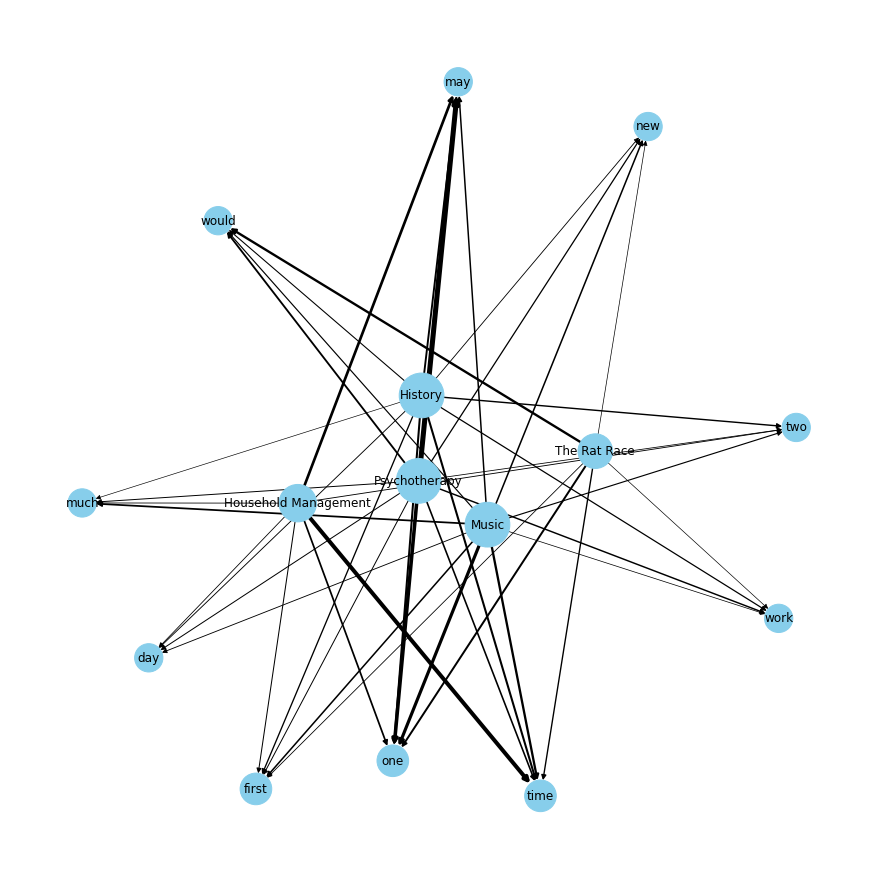

In [30]:
knowledgeGraph(bow_df ,
                n_top = 100 ,
                groupby = "book_name",
                no_outsumcols = 1,
                shared_only = True,
                degree_threshold = 3,
                max_width = 12,
                node_size_amplifier = 200,
                k = 2)

### *Sun burst*

In [31]:
freq_words_per_doc = getMostFreqWords(bow_df, 10,"book_name",no_outsumcols=1)

In [32]:
book_names = [x for x in sorted(y_train.unique()) for y in range(10)] 
common_words = [freq_words_per_doc[i].iloc[j, 0] for i in range(len(freq_words_per_doc)) for j in range(len(freq_words_per_doc[i]))]
word_freqs = [freq_words_per_doc[i].iloc[j, 1] for i in range(len(freq_words_per_doc)) for j in range(len(freq_words_per_doc[i]))]

In [33]:
data = dict(
    character=book_names,
    parent=common_words,
    value=word_freqs)

fig = px.sunburst(data, path=['character', 'parent'], values='value')
fig.show()

### *Hierarical Clustering with BOW*

In [34]:
X_train.head()

partition
0  milk   well flavour   strain   add rice   boil...
1  end ist dynasti   lid   royal tomb becam much ...
2  immedi predecessor   discov mr  carter        ...
3  albani   malibran   lind   parepa rosa   nilss...
4  member appear hereaft    the progress music un...

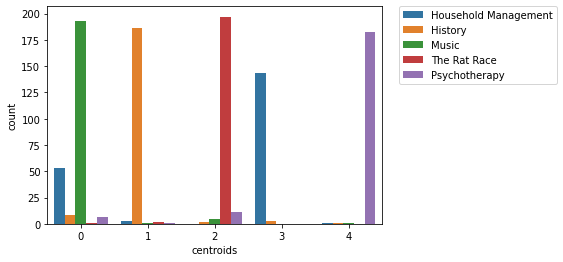

Kappa Score = 0.87625
Silhouette Score = 0.04750473180502071
Homogeneity Score = 0.7830276530468999
Coherence Score = 0.9106535567578516
Consistency Score within clusters = 34758.781292291394
Consistency Score between clusters = 16.441681748958153


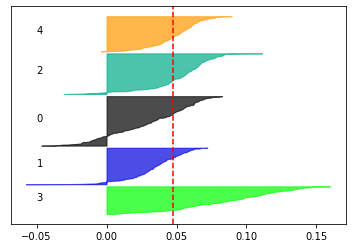

<Figure size 720x432 with 0 Axes>

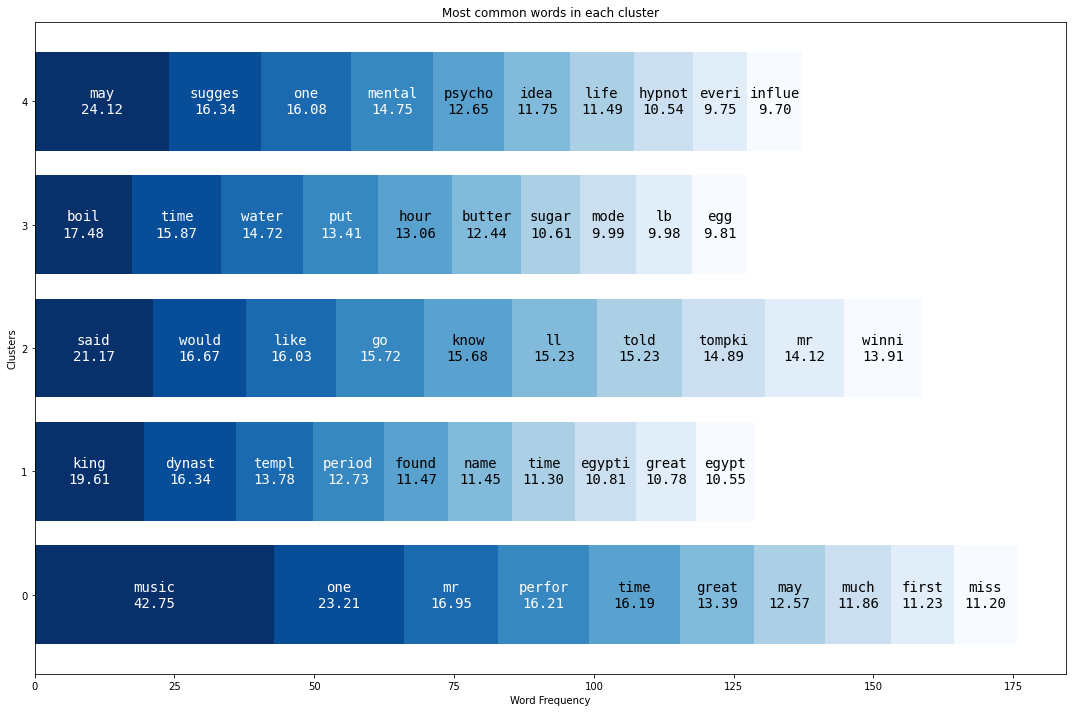

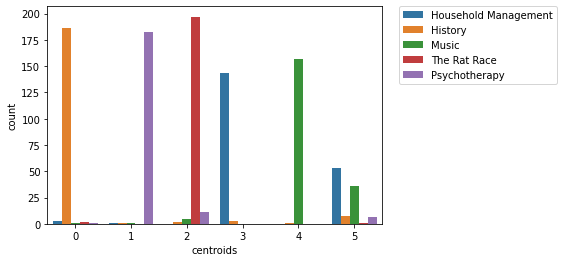

Kappa Score = 0.8975
Silhouette Score = 0.04621482777221774
Homogeneity Score = 0.8021904766414639
Coherence Score = 0.8967543881582588
Consistency Score within clusters = 24087.991691835025
Consistency Score between clusters = 14.93824651476485


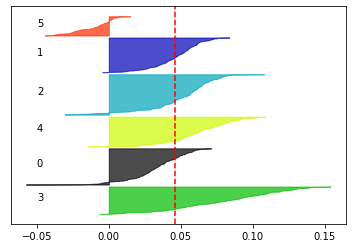

<Figure size 720x432 with 0 Axes>

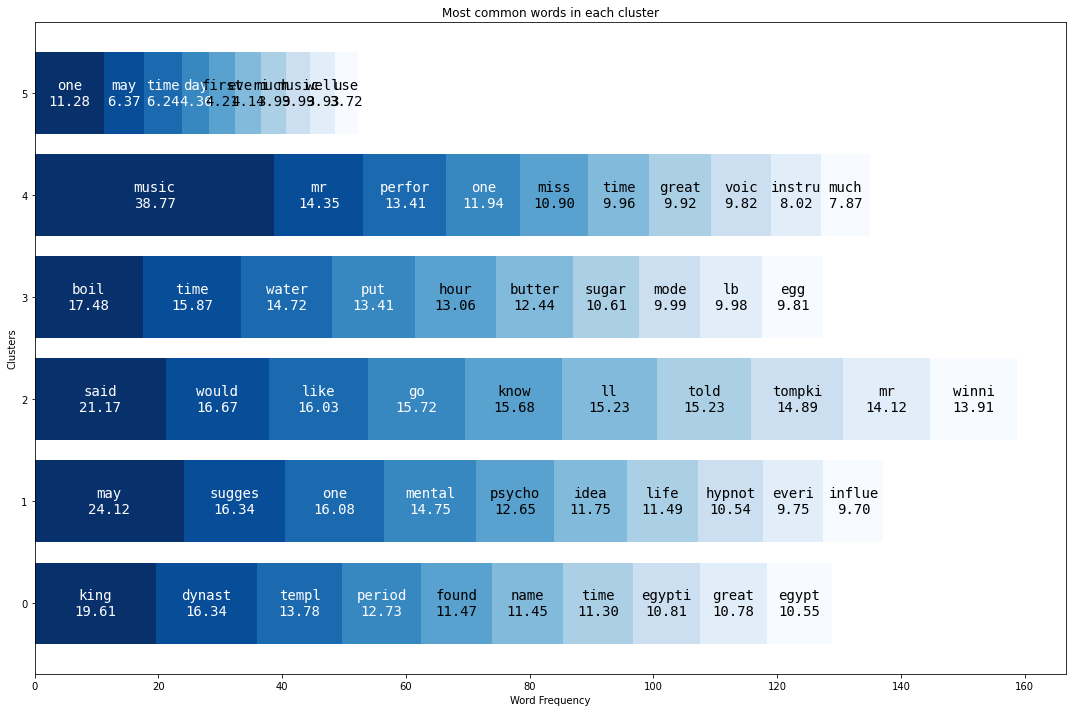

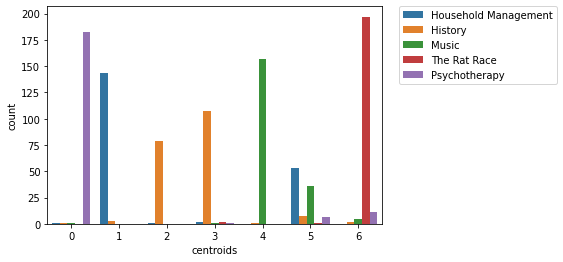

Kappa Score = 0.8975
Silhouette Score = 0.044999928213984915
Homogeneity Score = 0.8021904766414639
Coherence Score = 0.8988754435029246
Consistency Score within clusters = 18346.691152205494
Consistency Score between clusters = 13.633371549848059


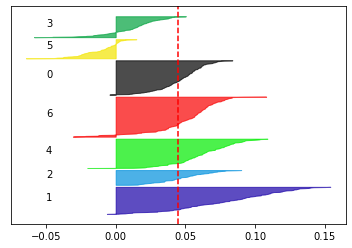

<Figure size 720x432 with 0 Axes>

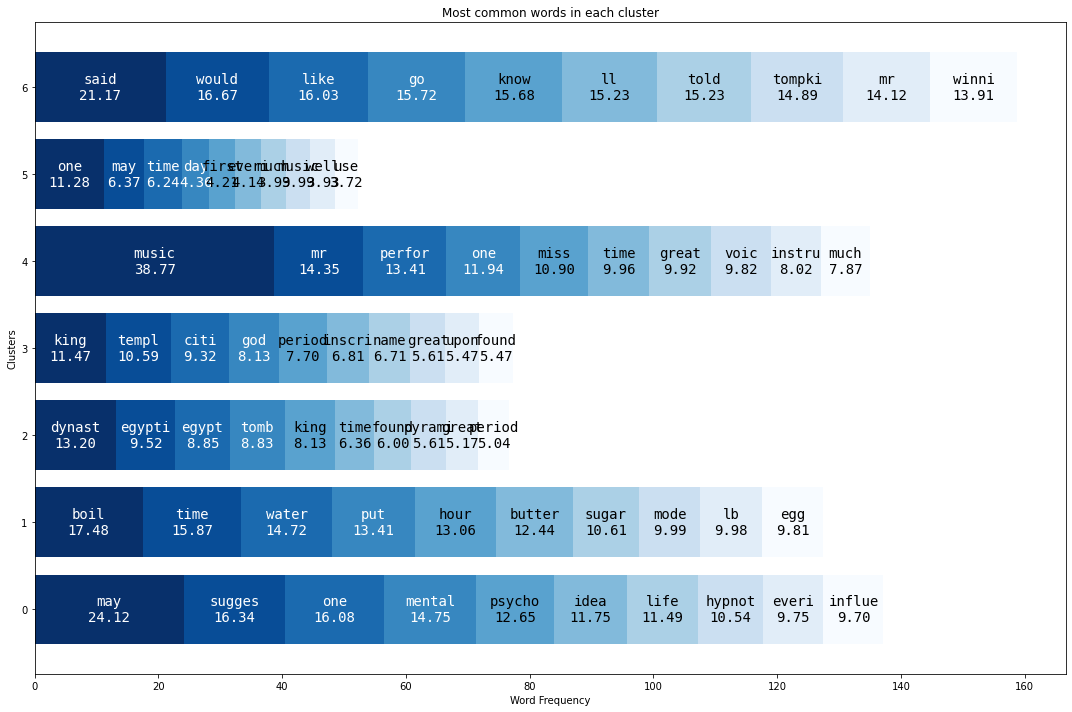

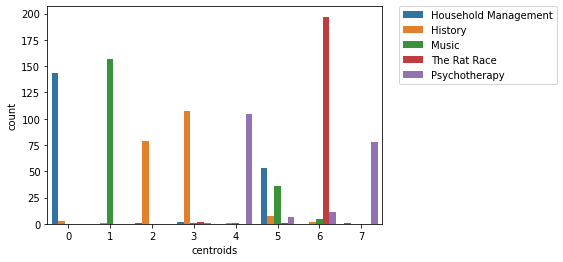

Kappa Score = 0.8975
Silhouette Score = 0.041532803558362315
Homogeneity Score = 0.8021904766414639
Coherence Score = 0.9008749437567436
Consistency Score within clusters = 14253.85951257402
Consistency Score between clusters = 12.603799908027392


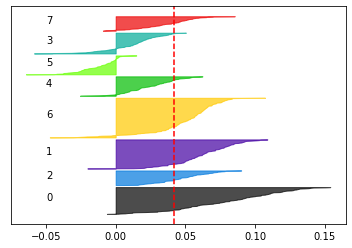

<Figure size 720x432 with 0 Axes>

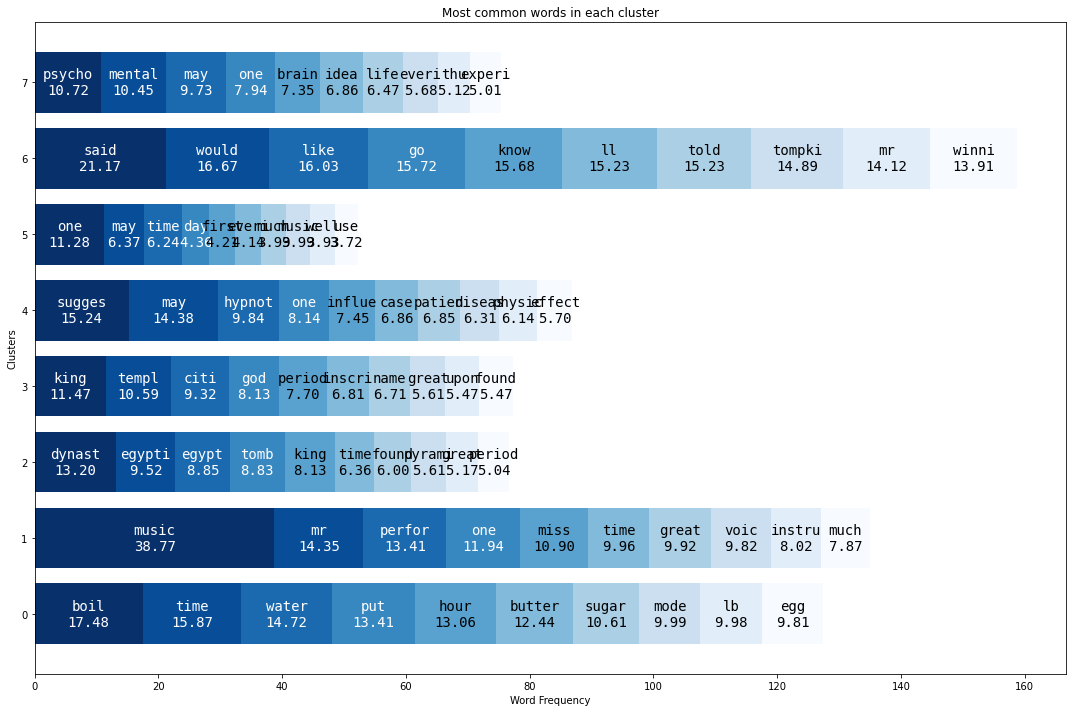

In [35]:
from sklearn.preprocessing import normalize

n_clusters = 5
x = bow_df.iloc[:,:-1]
y = bow_df.iloc[:,-1]

text_df = X_train.copy()
x = normalize(x)
x = pd.DataFrame(x, columns=bow_df.columns[:-1])

dist_metric = "euclidean"
link = "ward"

for n_clusters in range(5, 9):
  HieraricalClustering(n_clusters, x, text_df, y , dist_metric , link , "centroids", plot=False)
  

### *EM with Bow*

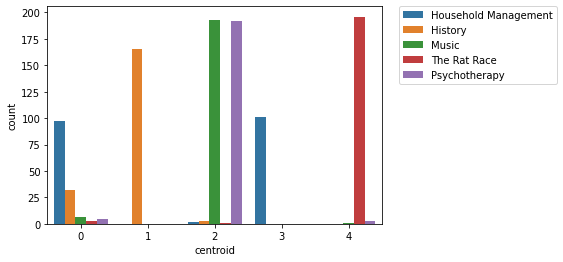

Kappa Score = 0.69
Silhouette Score = 0.011963178488663023
Homogeneity Score = 0.6973872623033356
Coherence Score = 0.8859668798744679
Consistency Score within clusters = 6237014.6
Consistency Score between clusters = 2240.921005382714


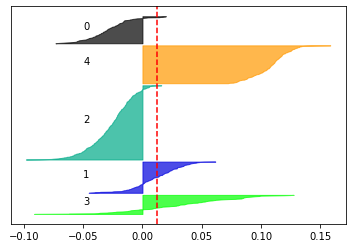

In [36]:
model_EM_bow= GaussianMixture(n_components=5,covariance_type='spherical', random_state=0)

bow_EM = bow_df.copy()
text_df = X_train.copy()

bow_EM["centroid"] = model_EM_bow.fit_predict(x)
text_df["centroid"] = model_EM_bow.predict(x)

plot_dominant_clusters(bow_EM, "centroid")
plt.show()
book_centroid_mapping_EM = find_dominant_clusters(bow_EM, "centroid")
evaluate_clustering(bow_EM, text_df,"centroid", book_centroid_mapping_EM)

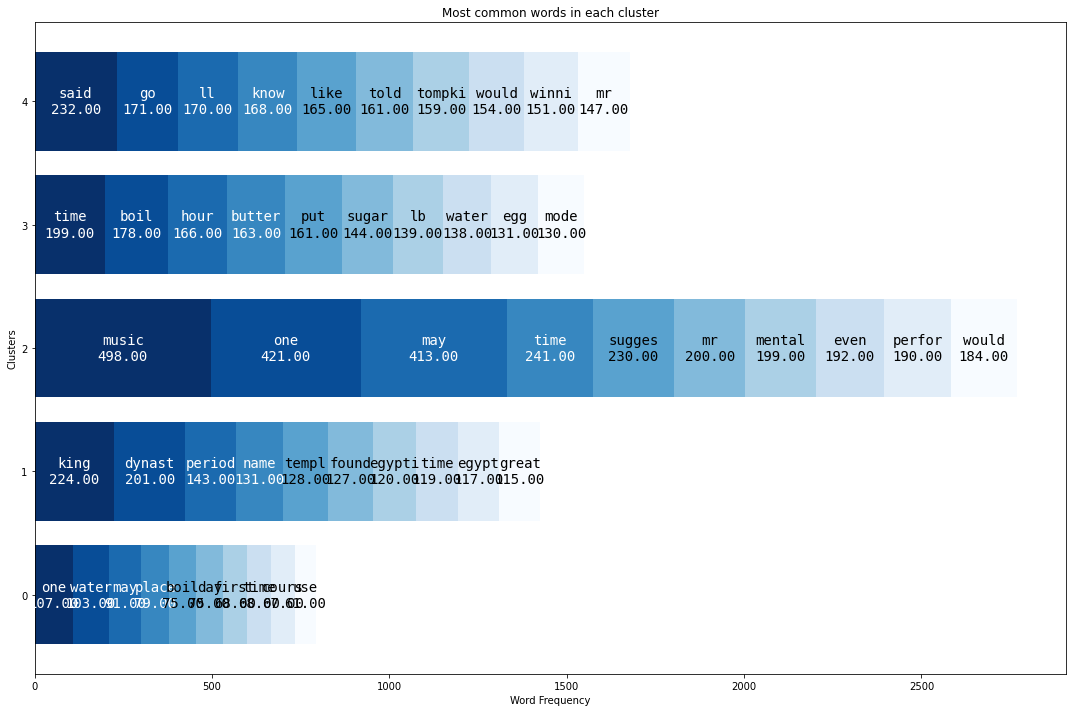

In [37]:
word_freqs = getMostFreqWords(bow_EM, 10,"centroid", no_outsumcols=2)
plot_word_freq_cluster(word_freqs)

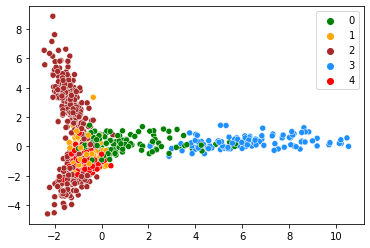

In [38]:
#pca with EM & Bow
pca = PCA(n_components=2).fit(bow_df.iloc[:, :-1])
data_bow = pca.transform(bow_df.iloc[:, :-1])
sns.scatterplot(data=bow_EM, hue='centroid', x=data_bow[:,0], y=data_bow[:,1],palette=['green','orange','brown','dodgerblue','red'])
plt.legend()

### *Kmeans with BOW*

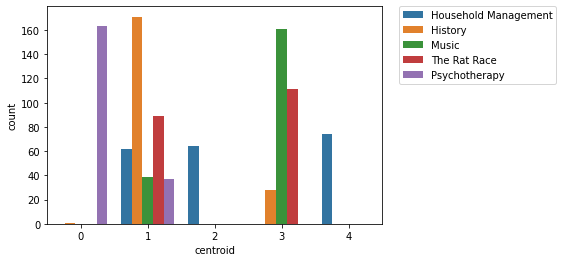

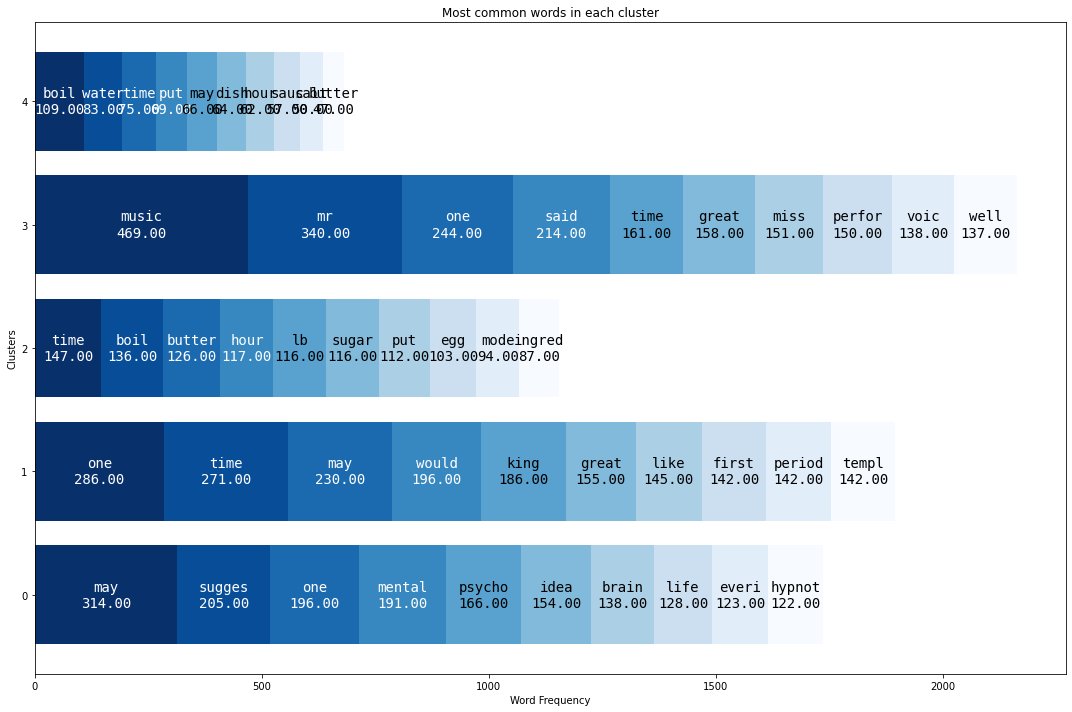

Kappa Score = 0.54125
Silhouette Score = 0.0072388855211928645
Homogeneity Score = 0.46900998166597574
Coherence Score = 0.8522084858464567
Consistency Score within clusters = 6691261.2
Consistency Score between clusters = 2049.4070577261446


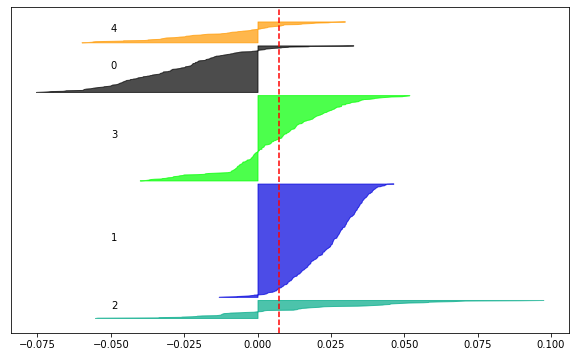

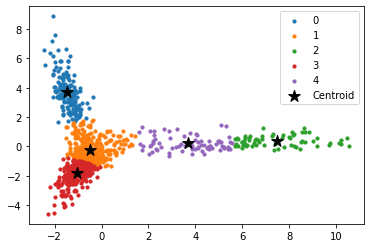

(     abil  abl  abnorm  abydo  ...  york  young             book_name  centroid
 0       0    0       0      0  ...     0      0  Household Management         2
 1       0    0       0      0  ...     0      0               History         1
 2       0    0       0      1  ...     0      0               History         3
 3       0    1       0      0  ...     0      0                 Music         3
 4       0    0       0      0  ...     0      0                 Music         1
 ..    ...  ...     ...    ...  ...   ...    ...                   ...       ...
 995     0    0       0      0  ...     0      0               History         1
 996     0    0       0      0  ...     0      0               History         1
 997     0    0       0      0  ...     0      0  Household Management         1
 998     0    0       0      0  ...     0      0  Household Management         4
 999     0    0       0      0  ...     0      0          The Rat Race         1
 
 [1000 rows x 1002 columns

In [39]:
kmeans = KMeans(n_clusters=5, init='k-means++', max_iter=1000, n_init=20)
apply_model(bow_df, text_df, kmeans)

# **TFIDF**

In [40]:
docs = joinDocPartitions(df)

vectorizer = TfidfVectorizer()
tfidf = vectorizer.fit(docs)
vocab = vectorizer.get_feature_names()

trans = vectorizer.transform(X_train["partition"])
tfidf_df = pd.DataFrame(trans.toarray(),
                        columns = [v for v in vocab])

tfidf_df['book_name'] = y_train.values
tfidf_df.head()

aah  aahm  aamu   ab  aba  ...  zon  zone  zoophyt  zorn             book_name
0  0.0   0.0   0.0  0.0  0.0  ...  0.0   0.0      0.0   0.0  Household Management
1  0.0   0.0   0.0  0.0  0.0  ...  0.0   0.0      0.0   0.0               History
2  0.0   0.0   0.0  0.0  0.0  ...  0.0   0.0      0.0   0.0               History
3  0.0   0.0   0.0  0.0  0.0  ...  0.0   0.0      0.0   0.0                 Music
4  0.0   0.0   0.0  0.0  0.0  ...  0.0   0.0      0.0   0.0                 Music

[5 rows x 11436 columns]

### *knowledge graph*

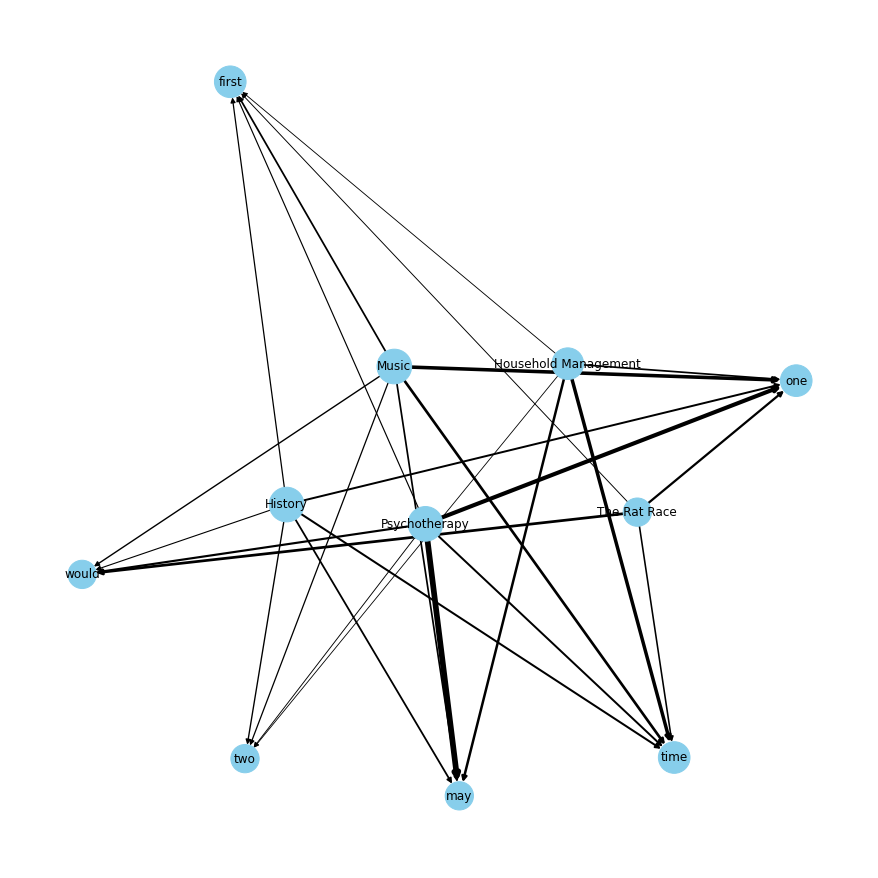

In [55]:
knowledgeGraph(tfidf_df ,
                n_top = 100 ,
                groupby = "book_name",
                no_outsumcols = 1,
                shared_only = True,
                degree_threshold = 3,
                max_width = 12,
                node_size_amplifier = 200,
                k = 2)

In [42]:
X_train.head()

partition
0  milk   well flavour   strain   add rice   boil...
1  end ist dynasti   lid   royal tomb becam much ...
2  immedi predecessor   discov mr  carter        ...
3  albani   malibran   lind   parepa rosa   nilss...
4  member appear hereaft    the progress music un...

### *Hierarical Clustering with TFIDF*

In [43]:
x = tfidf_df.iloc[:,:-1]
y = tfidf_df.iloc[:,-1]

text_df = X_train.copy()

dist_metrics = ["euclidean"]
links = ["ward"]

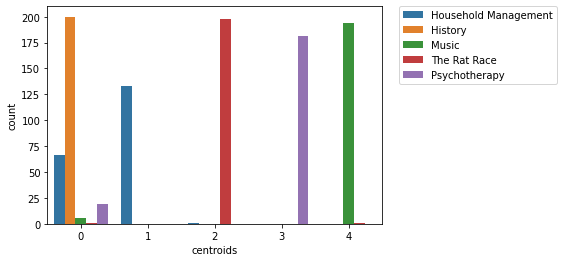

Kappa Score = 0.8825000000000001
Silhouette Score = 0.03331666825422996
Homogeneity Score = 0.833918572690077
Coherence Score = 0.9222742921898239
Consistency Score within clusters = 38762.80515381882
Consistency Score between clusters = 12.121541922028985


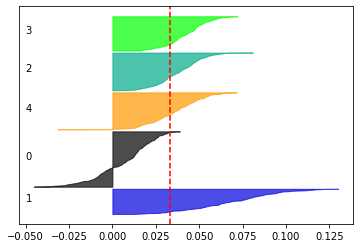

<Figure size 720x432 with 0 Axes>

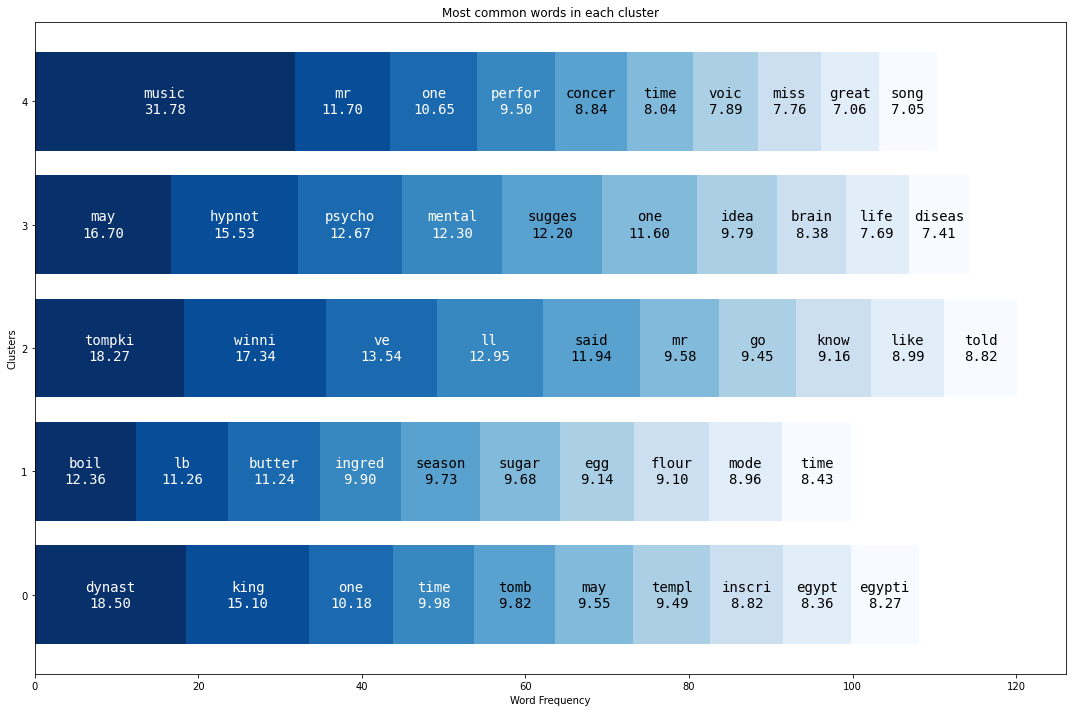

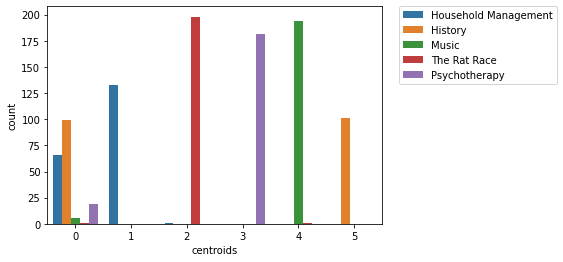

Kappa Score = 0.8825000000000001
Silhouette Score = 0.033848309797970814
Homogeneity Score = 0.833918572690077
Coherence Score = 0.9070834248849566
Consistency Score within clusters = 26110.42111240076
Consistency Score between clusters = 11.06710295073865


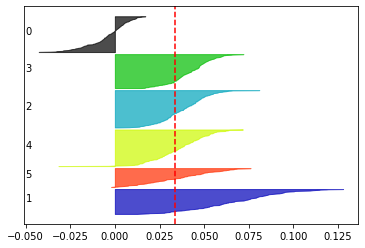

<Figure size 720x432 with 0 Axes>

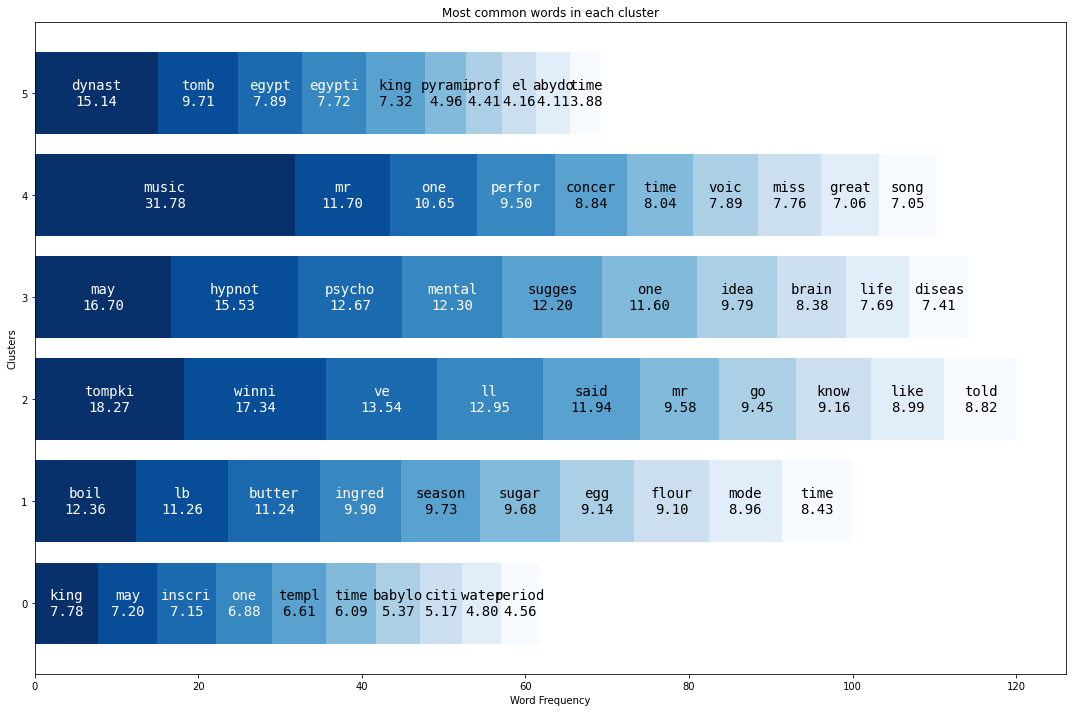

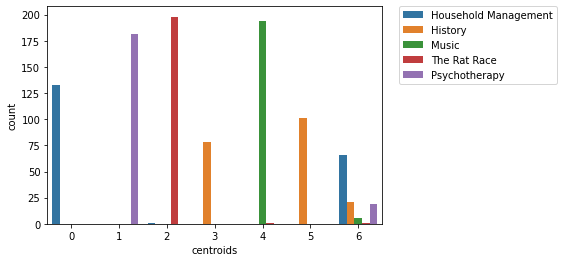

Kappa Score = 0.93875
Silhouette Score = 0.03421046705716434
Homogeneity Score = 0.8863732196197694
Coherence Score = 0.9105625630195316
Consistency Score within clusters = 19928.684496921614
Consistency Score between clusters = 10.222941408136732


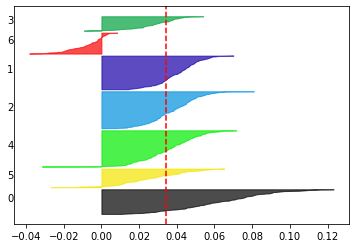

<Figure size 720x432 with 0 Axes>

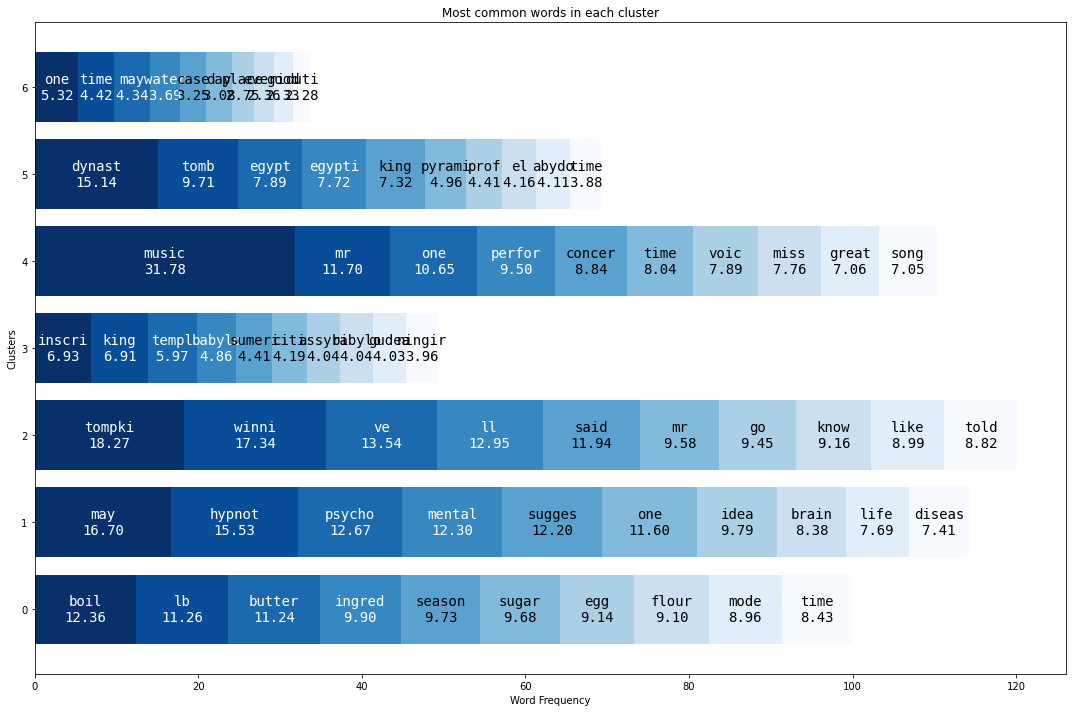

In [44]:
for n_clusters in range(5, 8):
  HClusteringModels(n_clusters , x, text_df, y ,dist_metrics , links , "centroids",True)

### *EM with TFIDF*

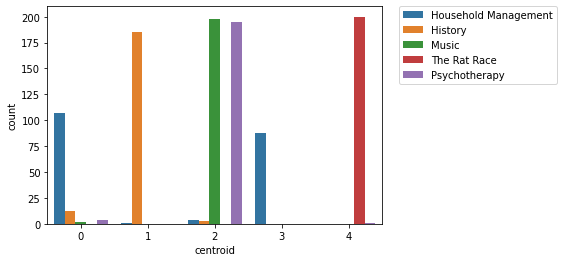

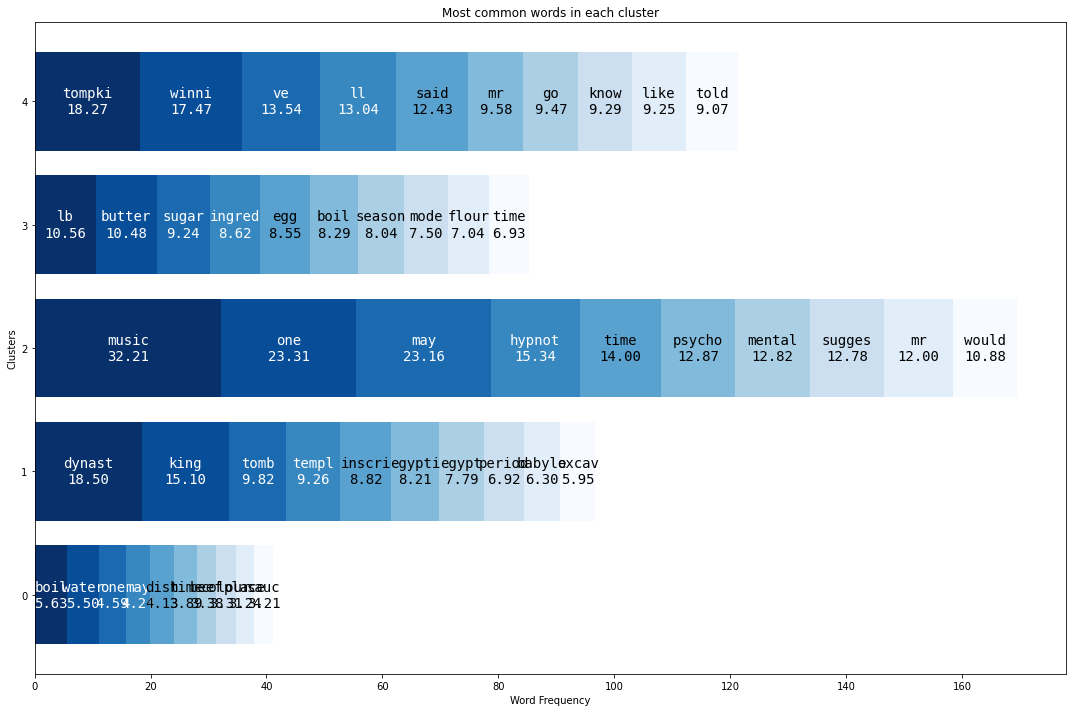

Kappa Score = 0.7224999999999999
Silhouette Score = 0.026893414909284333
Homogeneity Score = 0.7502688062182256
Coherence Score = 0.8876485742942283
Consistency Score within clusters = 47401.40993575285
Consistency Score between clusters = 10.495884339369631


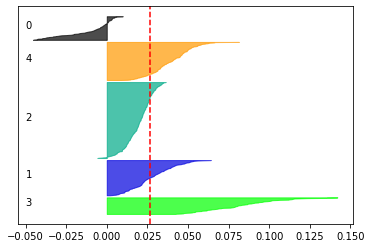

In [45]:
model_EM_tf= GaussianMixture(n_components=5,covariance_type='spherical', random_state=0)

tfidf_EM = tfidf_df.copy()
text_df = X_train.copy()

tfidf_EM["centroid"] = model_EM_tf.fit_predict(tfidf_df.iloc[:, :-1])
text_df["centroid"] =  model_EM_tf.predict(tfidf_df.iloc[:, :-1])
plot_dominant_clusters(tfidf_EM, "centroid")
plt.show()

freq_words_per_cluster = getMostFreqWords(tfidf_EM, 10, "centroid",no_outsumcols=2)
plot_word_freq_cluster(freq_words_per_cluster)

book_centroid_mapping_EM = find_dominant_clusters(tfidf_EM, "centroid")
evaluate_clustering(tfidf_EM, text_df, "centroid", book_centroid_mapping_EM)

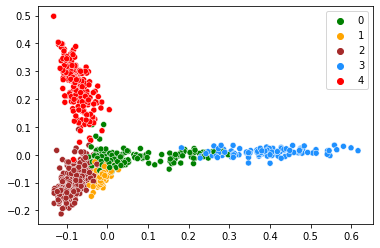

In [46]:
#pca with EM & tfidf
pca = PCA(n_components=2).fit(tfidf_df.iloc[:, :-1])
data_tfidf = pca.transform(tfidf_df.iloc[:, :-1])
sns.scatterplot(data=bow_EM, hue='centroid', x=data_tfidf[:,0], y=data_tfidf[:,1],palette=['green','orange','brown','dodgerblue','red'])
plt.legend()

### *Kmeans with TFIDF*

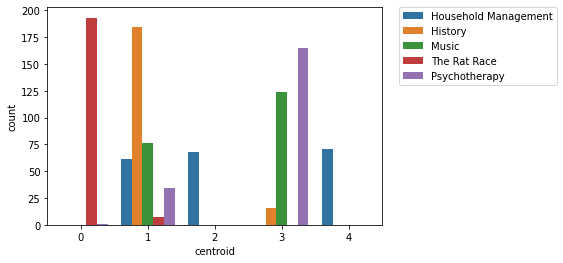

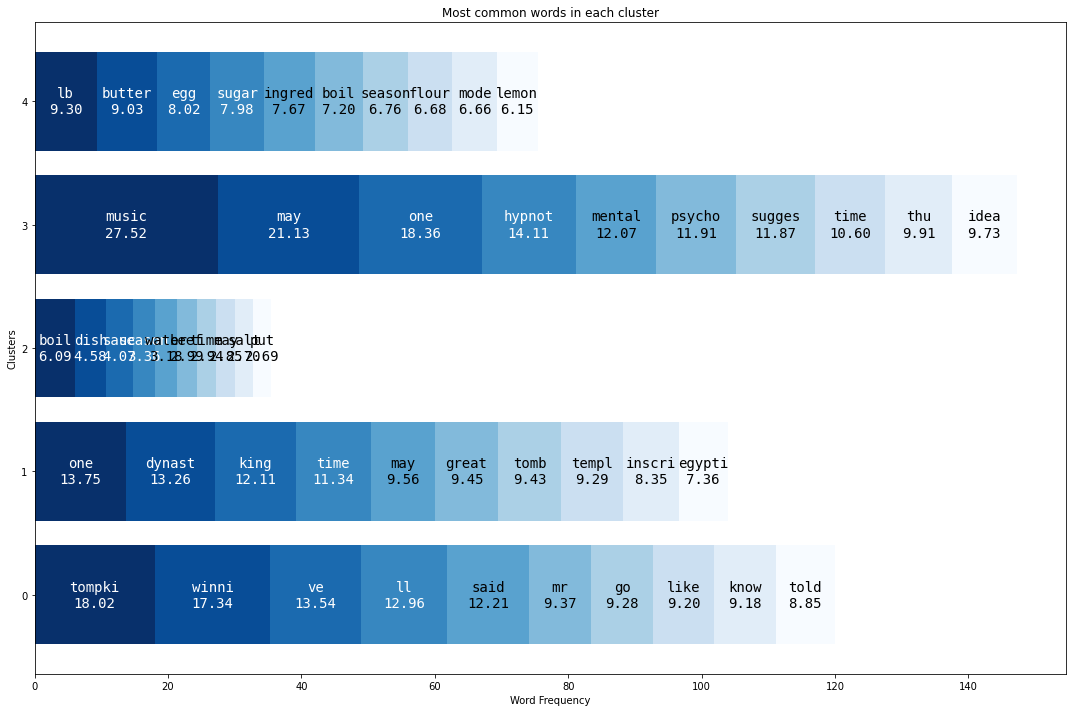

Kappa Score = 0.6012500000000001
Silhouette Score = 0.018563027257158606
Homogeneity Score = 0.5487782519635479
Coherence Score = 0.8940609861204498
Consistency Score within clusters = 50478.23307245764
Consistency Score between clusters = 9.40186918168469


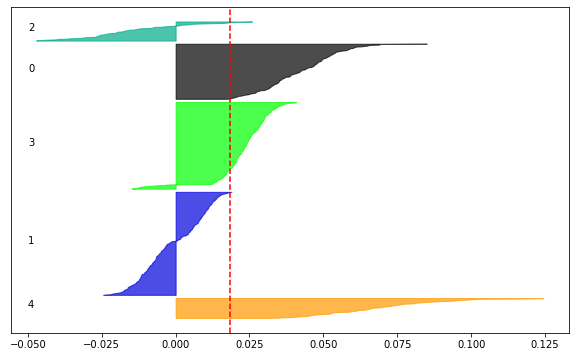

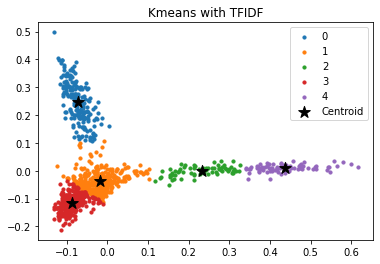

(     aah  aahm  aamu   ab  ...  zoophyt  zorn             book_name  centroid
 0    0.0   0.0   0.0  0.0  ...      0.0   0.0  Household Management         4
 1    0.0   0.0   0.0  0.0  ...      0.0   0.0               History         1
 2    0.0   0.0   0.0  0.0  ...      0.0   0.0               History         1
 3    0.0   0.0   0.0  0.0  ...      0.0   0.0                 Music         3
 4    0.0   0.0   0.0  0.0  ...      0.0   0.0                 Music         3
 ..   ...   ...   ...  ...  ...      ...   ...                   ...       ...
 995  0.0   0.0   0.0  0.0  ...      0.0   0.0               History         1
 996  0.0   0.0   0.0  0.0  ...      0.0   0.0               History         3
 997  0.0   0.0   0.0  0.0  ...      0.0   0.0  Household Management         1
 998  0.0   0.0   0.0  0.0  ...      0.0   0.0  Household Management         4
 999  0.0   0.0   0.0  0.0  ...      0.0   0.0          The Rat Race         0
 
 [1000 rows x 11437 columns],
 {0: 'The Rat Race',

In [47]:
kmeans = KMeans(n_clusters=5, init='k-means++', max_iter=1000, n_init=20)
apply_model(tfidf_df,text_df, kmeans,'Kmeans with TFIDF')

# **Doc2Vec**

### *Transformation*

In [48]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument 

In [49]:
def doc_data(X_train, y_train):
    # To get list of sentences
    doc_train = X_train.values.reshape(X_train.values.shape[0])
    label_train = y_train.values.reshape(y_train.values.shape[0])
    return doc_train, label_train

doc_train, label_train = doc_data(X_train, y_train)

In [50]:
def Doc2Vec_Model(trainingData , vector_siz , min_word_count , no_epoch ):
    train_data = [TaggedDocument( doc.split(), [i]) for i, doc in enumerate(trainingData)]

    #Train
    model = Doc2Vec(vector_size=vector_siz, min_count=min_word_count, epochs=no_epoch)
    #build vocab
    model.build_vocab(train_data)
    #train
    model.train(train_data, total_examples=model.corpus_count, epochs=model.epochs)

    return model

In [51]:
"""
input:
  model_ : model trained to get doc2vec
  documents : list of sentences
  labels : list of labels

output : dataframe with doc2vec vector and label
"""

def Doc2Vec_transform(model_,df):
    
    newdf = df.copy()

    docs = [doc.split()for i, doc in enumerate(newdf['partition'])]

    vectors = [model_.infer_vector(doc) for doc in docs]

    newdf = pd.DataFrame(np.array(vectors))
    newdf['book_name'] = np.array(df['book_name'])
    return newdf
#doc2vec_df = Doc2Vec_transform(doc2vecModel, df)

In [52]:
doc2vecModel = Doc2Vec_Model(doc_train, vector_siz=50, min_word_count = 2, no_epoch = 20)

In [53]:
doc2vec_df = pd.read_csv('doc2vec_Data.csv')

In [ ]:
doc2vec_df

0         1         2  ...        48        49             book_name
0   -0.485529  0.602129 -0.232419  ...  1.340258 -0.510901  Household Management
1    0.290098 -1.043401  0.068958  ... -1.034223 -0.261242               History
2    0.289130 -0.468212  0.047396  ... -0.924526 -0.540081               History
3   -0.344223 -0.283691 -0.728178  ...  0.071505  0.020429                 Music
4   -0.150528  0.487984 -1.452028  ...  0.014470 -0.081004                 Music
..        ...       ...       ...  ...       ...       ...                   ...
995  0.363916 -0.513321 -0.660465  ... -0.441029 -0.400378               History
996 -0.040117 -0.471117 -0.729288  ... -0.195082 -0.365282               History
997 -0.425224  0.363209 -0.709698  ...  1.596732 -0.391310  Household Management
998 -0.459820  0.278203 -0.560073  ...  0.280991 -0.320834  Household Management
999  0.149640  0.262112  0.181243  ... -0.490682 -0.329895          The Rat Race

[1000 rows x 51 columns]

### *Hierarical Clustering with DOC2Vec*

In [ ]:
n_clusters = 10
x = doc2vec_df.iloc[:,:-1]
y = doc2vec_df.iloc[:,-1]

text_df = X_train.copy()
dist_metrics = ["euclidean"]
links = ['ward']

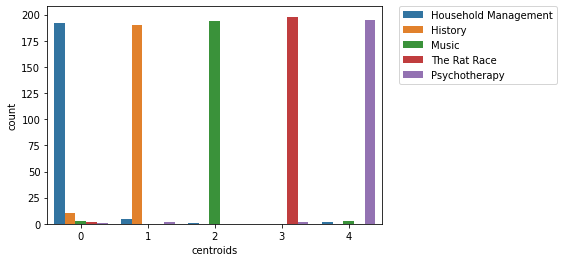

Kappa Score = 0.96125
Silhouette Score = 0.36362913736153896
Homogeneity Score = 0.9057428255900769
Coherence Score = 0.9058913303676406
Consistency Score within clusters = 204578.11805630874
Consistency Score between clusters = 1504.6345199148252


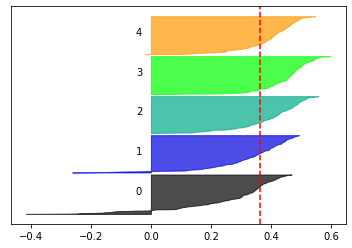

<Figure size 720x432 with 0 Axes>

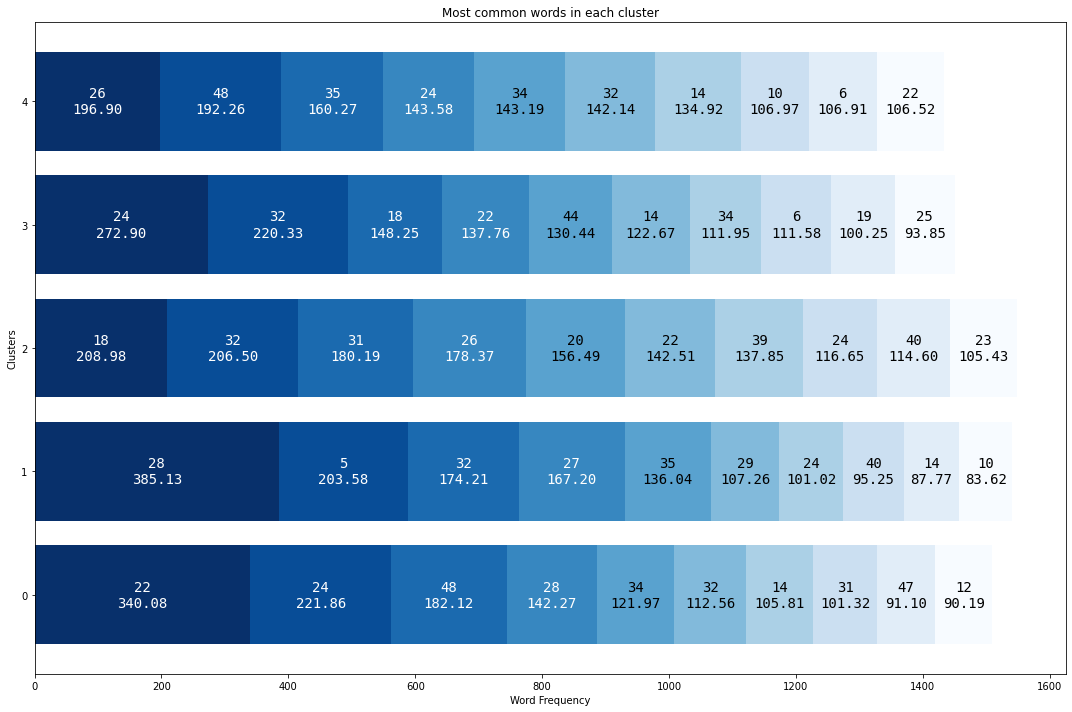

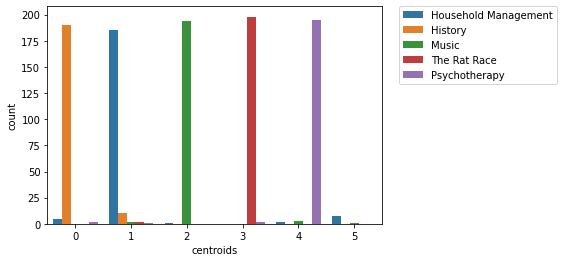

Kappa Score = 0.96125
Silhouette Score = 0.36816659686018977
Homogeneity Score = 0.9057428255900769
Coherence Score = 0.9064064265081758
Consistency Score within clusters = 152890.75715707362
Consistency Score between clusters = 1321.6907462019742


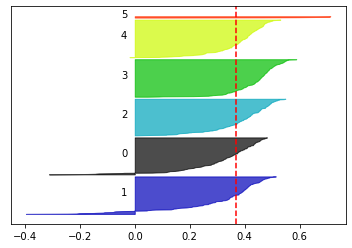

<Figure size 720x432 with 0 Axes>

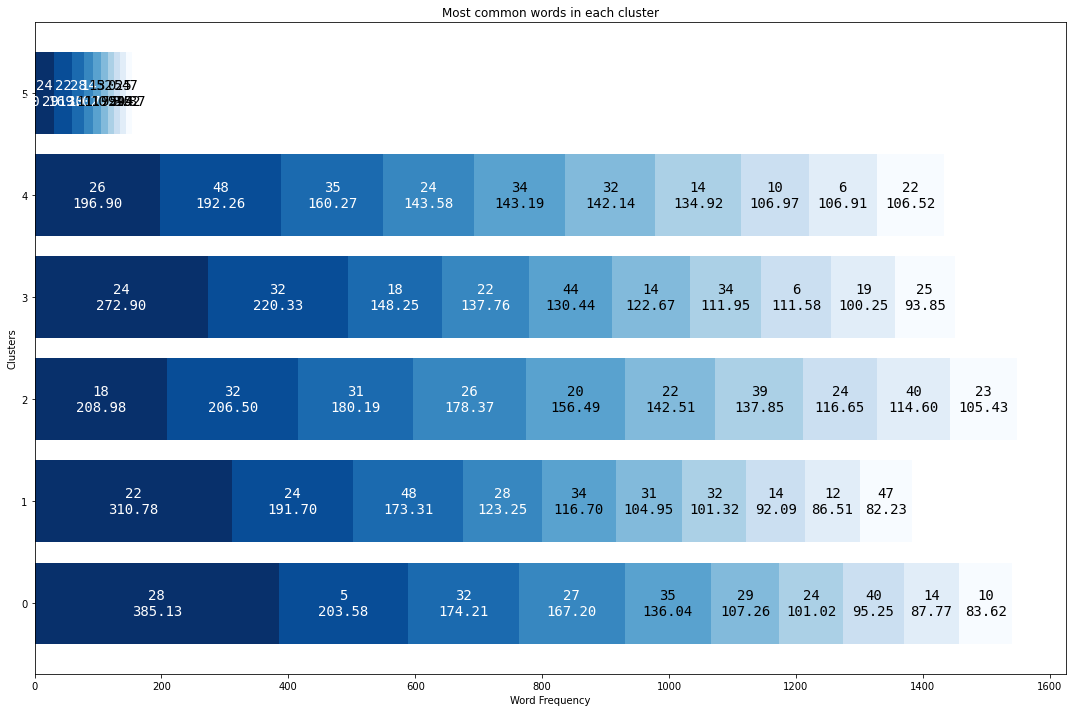

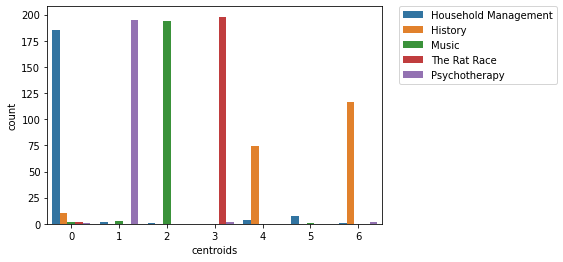

Kappa Score = 0.96125
Silhouette Score = 0.3352271458398487
Homogeneity Score = 0.9057428255900769
Coherence Score = 0.9024896555573196
Consistency Score within clusters = 110881.27609952484
Consistency Score between clusters = 1165.9369869448


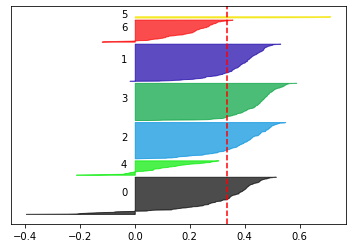

<Figure size 720x432 with 0 Axes>

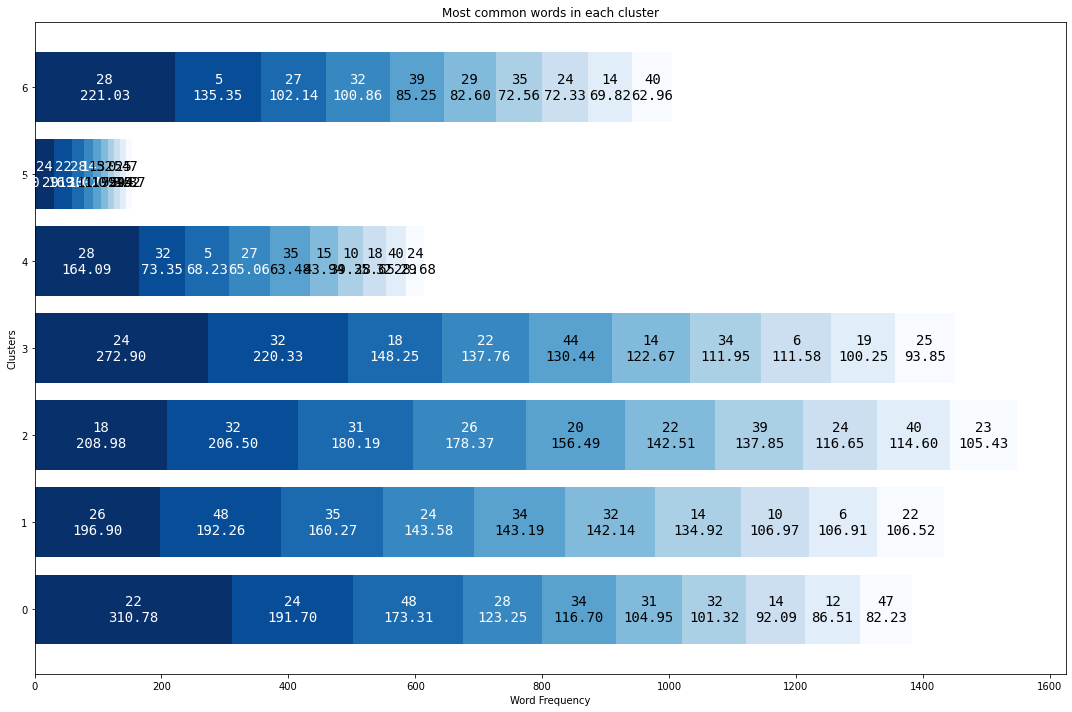

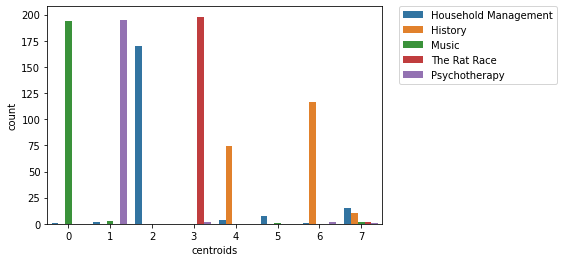

Kappa Score = 0.96125
Silhouette Score = 0.2740731927951659
Homogeneity Score = 0.9057428255900769
Coherence Score = 0.9030813734169657
Consistency Score within clusters = 87640.90464461174
Consistency Score between clusters = 1039.1684182931112


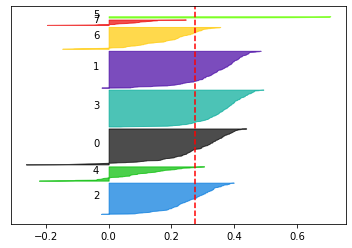

<Figure size 720x432 with 0 Axes>

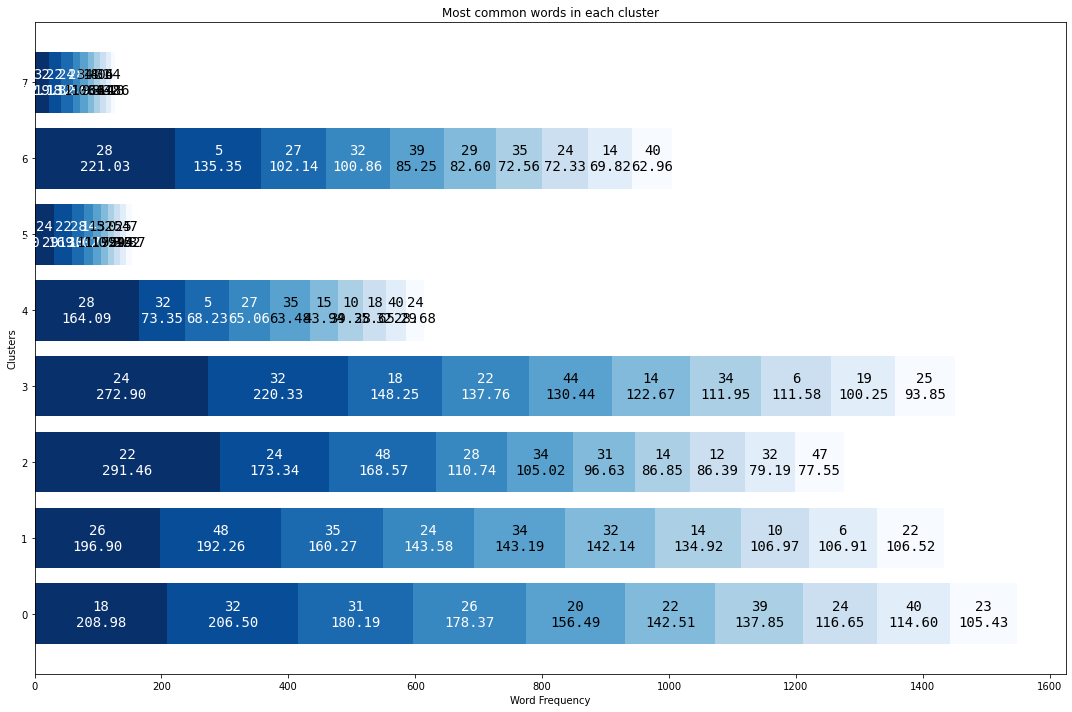

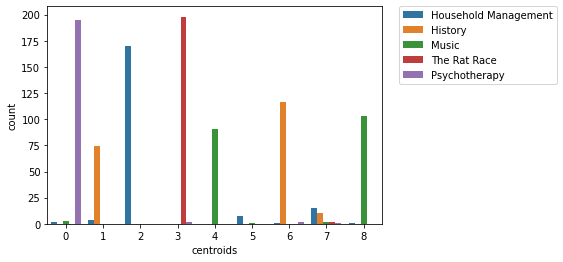

Kappa Score = 0.96125
Silhouette Score = 0.24288827996057347
Homogeneity Score = 0.9057428255900769
Coherence Score = 0.9018081798866303
Consistency Score within clusters = 66761.49347601354
Consistency Score between clusters = 939.1151491083588


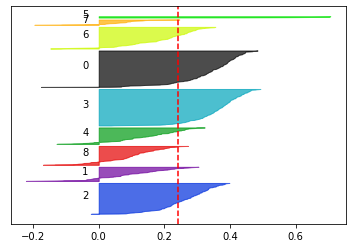

<Figure size 720x432 with 0 Axes>

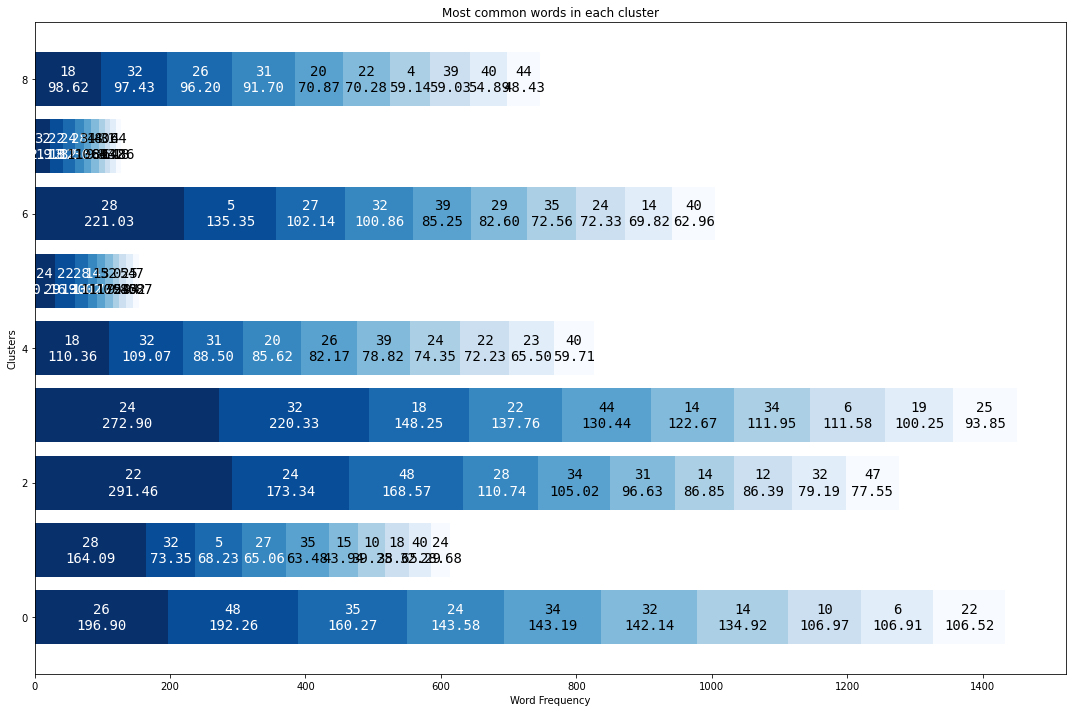

In [ ]:
for n_clusters in range(5, 10):
  HClusteringModels(n_clusters, x, text_df, y, dist_metrics , links , "centroids", True)

### EM With Doc2Vec

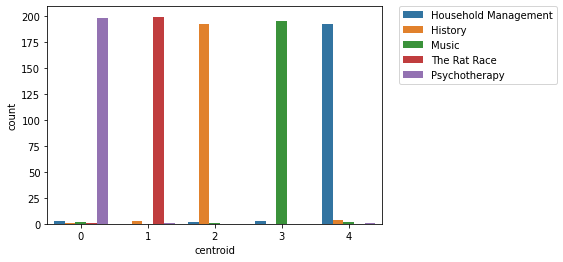

Kappa Score = 0.97
Silhouette Score = 0.37222302119894823
Homogeneity Score = 0.9184012850264492
Coherence Score = 0.8949763415832269
Consistency Score within clusters = 198589.48376541323
Consistency Score between clusters = 1528.8151428831893


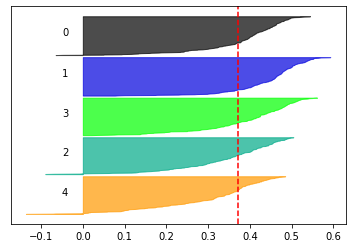

In [ ]:
model_EM_doc= GaussianMixture(n_components=5,covariance_type='spherical', random_state=0)
doc_EM = doc2vec_df.copy()
text_df = X_train.copy()

doc_EM["centroid"] = model_EM_doc.fit_predict(doc2vec_df.iloc[: , :-1])
text_df["centroid"] = model_EM_doc.predict(doc2vec_df.iloc[: , :-1])

plot_dominant_clusters(doc_EM, "centroid")
plt.show()
book_centroid_mapping_EM = find_dominant_clusters(doc_EM, "centroid")
evaluate_clustering(doc_EM, text_df, "centroid", book_centroid_mapping_EM)

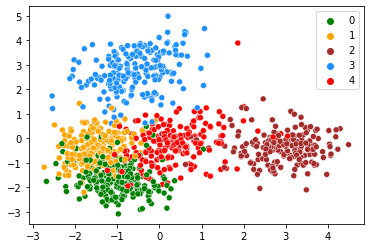

In [ ]:
#pca with EM & Doc2Vec
pca = PCA(n_components=2).fit(doc2vec_df.iloc[: , :-1])
data_doc = pca.transform(doc2vec_df.iloc[: , :-1])
sns.scatterplot(data=doc_EM, hue='centroid', x=data_doc[:,0], y=data_doc[:,1],palette=['green','orange','brown','dodgerblue','red'])
plt.legend()

### *kmeans with Doc2Vec*

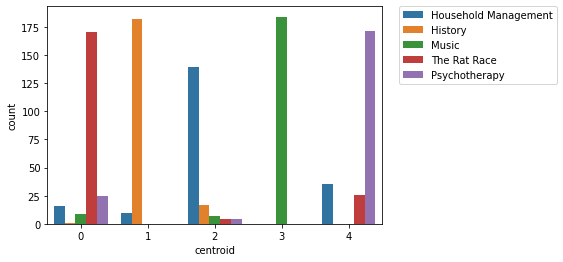

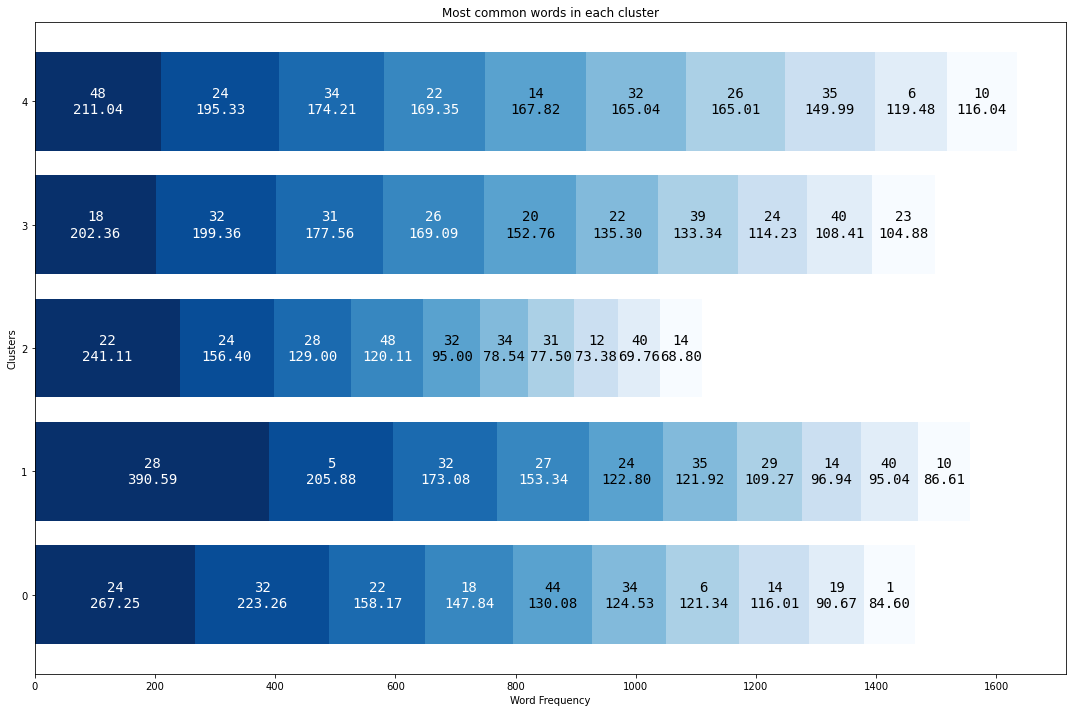

Kappa Score = 0.8075
Silhouette Score = 0.262873210331695
Homogeneity Score = 0.6829258994884954
Coherence Score = 0.8736330731448374
Consistency Score within clusters = 253328.29378473418
Consistency Score between clusters = 1278.506282457548


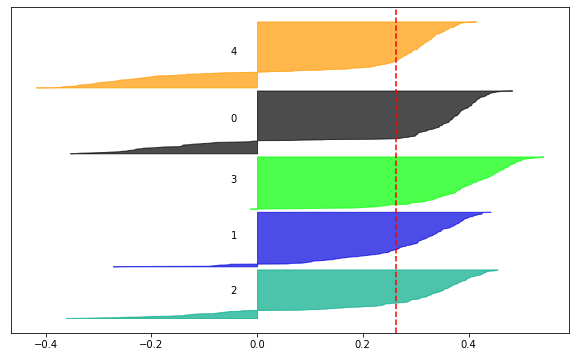

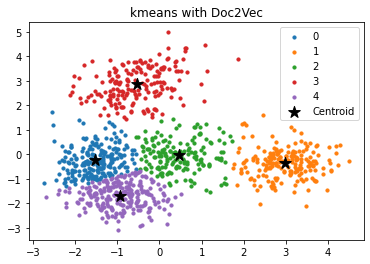

(            0         1         2  ...        49             book_name  centroid
 0   -0.485529  0.602129 -0.232419  ... -0.510901  Household Management         2
 1    0.290098 -1.043401  0.068958  ... -0.261242               History         1
 2    0.289130 -0.468212  0.047396  ... -0.540081               History         1
 3   -0.344223 -0.283691 -0.728178  ...  0.020429                 Music         3
 4   -0.150528  0.487984 -1.452028  ... -0.081004                 Music         3
 ..        ...       ...       ...  ...       ...                   ...       ...
 995  0.363916 -0.513321 -0.660465  ... -0.400378               History         1
 996 -0.040117 -0.471117 -0.729288  ... -0.365282               History         1
 997 -0.425224  0.363209 -0.709698  ... -0.391310  Household Management         4
 998 -0.459820  0.278203 -0.560073  ... -0.320834  Household Management         2
 999  0.149640  0.262112  0.181243  ... -0.329895          The Rat Race         0
 
 [1000 rows x 

In [ ]:
kmeans = KMeans(n_clusters=5, init='k-means++', max_iter=1000, n_init=20,random_state=10)
apply_model(doc2vec_df, text_df, kmeans,'kmeans with Doc2Vec')

# **LDA**

In [ ]:
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD

In [ ]:
X_train.head()

partition
0  milk   well flavour   strain   add rice   boil...
1  end ist dynasti   lid   royal tomb becam much ...
2  immedi predecessor   discov mr  carter        ...
3  albani   malibran   lind   parepa rosa   nilss...
4  member appear hereaft    the progress music un...

In [ ]:
lda_count_vectorizer = CountVectorizer(min_df=20)
data_vectorized = lda_count_vectorizer.fit_transform(X_train.partition)
data_dense = data_vectorized.todense()
print("Percentage of nonzero: ", ((data_dense > 0).sum()/data_dense.size)*100, "%")

Percentage of nonzero:  5.361771944216571 %


In [ ]:
# best n_components 5, learning decay .5 

param_grid = {'n_components': np.arange(5, 8), 'learning_decay': [.5, .7, .9], 'random_state': [4]}

lda = LatentDirichletAllocation()
model = GridSearchCV(lda, param_grid=param_grid)
model.fit(data_vectorized)

GridSearchCV(cv=None, error_score=nan,
             estimator=LatentDirichletAllocation(batch_size=128,
                                                 doc_topic_prior=None,
                                                 evaluate_every=-1,
                                                 learning_decay=0.7,
                                                 learning_method='batch',
                                                 learning_offset=10.0,
                                                 max_doc_update_iter=100,
                                                 max_iter=10,
                                                 mean_change_tol=0.001,
                                                 n_components=10, n_jobs=None,
                                                 perp_tol=0.1,
                                                 random_state=None,
                                                 topic_word_prior=None,
                                                 tota

In [ ]:
best_lda_model = model.best_estimator_

print("Best Model's Params: ", model.best_params_)
print("Best Log Likelihood Score: ", model.best_score_)
print("Model Perplexity: ", best_lda_model.perplexity(data_vectorized))

Best Model's Params:  {'learning_decay': 0.5, 'n_components': 5, 'random_state': 4}
Best Log Likelihood Score:  -117833.68186657701
Model Perplexity:  608.9590657751203


In [ ]:
unknown_cluster = 5

lda_output = best_lda_model.transform(data_vectorized)
topic_names = [f"Topic {i}" for i in range(best_lda_model.n_components)]

df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns=topic_names)
dominant_topic = np.empty((df_document_topic.shape[0], 1))

'''for i in range(df_document_topic.values.shape[0]):
  if(np.max(df_document_topic.values[i]) >= 0.5):
    dominant_topic[i] = np.argmax(df_document_topic.values[i])
  else:
    dominant_topic[i] = unknown_cluster'''

dominant_topic = np.argmax(df_document_topic.values, axis=1)

df_document_topic["book_name"] = y_train.values

df_document_topic['dominant_topic'] = dominant_topic

text_df = X_train.copy()
text_df['dominant_topic'] = dominant_topic

df_document_topic

Topic 0  Topic 1  Topic 2  ...  Topic 4             book_name dominant_topic
0       0.00     0.00     0.00  ...     0.00  Household Management              3
1       0.07     0.00     0.91  ...     0.00               History              2
2       0.00     0.00     0.90  ...     0.10               History              2
3       0.86     0.06     0.07  ...     0.00                 Music              0
4       0.77     0.14     0.00  ...     0.09                 Music              0
..       ...      ...      ...  ...      ...                   ...            ...
995     0.00     0.00     0.99  ...     0.00               History              2
996     0.00     0.04     0.91  ...     0.05               History              2
997     0.13     0.56     0.00  ...     0.00  Household Management              1
998     0.11     0.00     0.05  ...     0.00  Household Management              3
999     0.00     0.00     0.00  ...     0.99          The Rat Race              4

[1000 rows x 7 columns]

{3: 'Household Management', 2: 'History', 0: 'Music', 4: 'The Rat Race', 1: 'Psychotherapy'}
Kappa Score = 0.94
Silhouette Score = 0.7798304565969258
Homogeneity Score = 0.8689964161528669
Coherence Score = 0.9175290710047671
Consistency Score within clusters = 1807.3841400000001
Consistency Score between clusters = 112.32093641809959


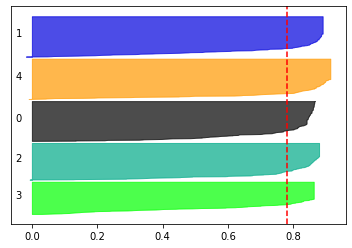

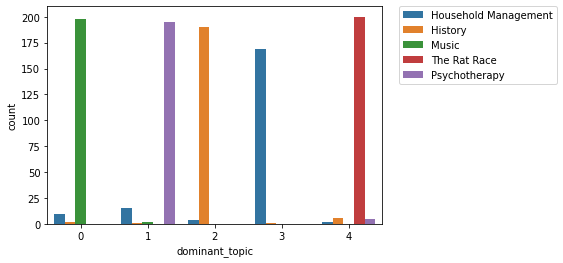

In [ ]:
book_centroid_mapping_LDA = find_dominant_clusters(df_document_topic, 'dominant_topic')
print(book_centroid_mapping_LDA)
evaluate_clustering(df_document_topic, text_df, 'dominant_topic', book_centroid_mapping_LDA)
plt.show()
sns.countplot(x = "dominant_topic",       
            hue = "book_name",  # group variable name
            data = df_document_topic)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

# **Champion Model**

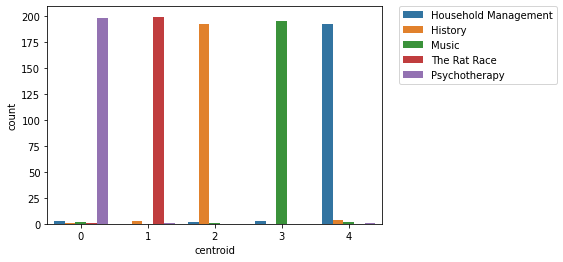

Kappa Score = 0.97
Silhouette Score = 0.37222302119894823
Homogeneity Score = 0.9184012850264492
Coherence Score = 0.8949763415832269
Consistency Score within clusters = 198589.48376541323
Consistency Score between clusters = 1528.8151428831893


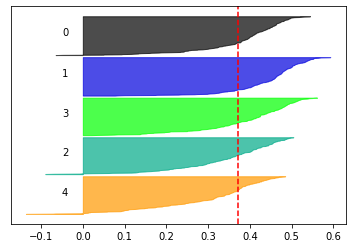

In [ ]:
model_EM_doc = GaussianMixture(n_components=5,covariance_type='spherical', random_state=0)
doc_EM = doc2vec_df.copy()
text_df = X_train.copy()

doc_EM["centroid"] = model_EM_doc.fit_predict(doc2vec_df.iloc[: , :-1])
text_df["centroid"] = model_EM_doc.predict(doc2vec_df.iloc[: , :-1])

plot_dominant_clusters(doc_EM, "centroid")
plt.show()
book_centroid_mapping_EM = find_dominant_clusters(doc_EM, "centroid")
evaluate_clustering(doc_EM, text_df, "centroid", book_centroid_mapping_EM)

### **error analysis**

In [ ]:
def get_keyword_ratios(df, groupby_col, target_cls, keywords_dict):
  ratios = {}
  sub_df = df[df[groupby_col] == target_cls]
  all_cls = df[groupby_col].unique()
  total = 0
  for partition in sub_df["partition"].values:
    for cls_name, keywords in keywords_dict.items():
      words = partition.split()
      count = sum([1 for i in range(len(words)) if words[i] in keywords])
      ratios[cls_name] = ratios.get(cls_name, 0) + count
      total += count

  ratios_norm = {k: v/total for k,v in ratios.items()}
  return ratios_norm

def get_keyword_ratios_single_class(df, groupby_col, target_cls, keywords):
  ratios = {w: 0 for w in keywords}
  sub_df = df[df[groupby_col] == target_cls]
  total = 0
  for partition in sub_df["partition"].values:
    for word in partition.split():
      for kw in keywords:
        if(word == kw):
          ratios[kw] = ratios.get(kw, 0) + 1
          total += 1

  ratios_norm = {k: v/total for k,v in ratios.items()}
  return ratios_norm

def visualize_keywords(word_freqs, title):
  word_freqs = sorted(word_freqs.items())

  words = [x[0] for x in word_freqs]
  count = [x[1] for x in word_freqs]

  fig, ax = plt.subplots(figsize=(20, 8))
  sns.barplot(words, count).set_title(title)


In [ ]:
cluster_df = doc_EM
book_centroid_mapping = book_centroid_mapping_EM

In [ ]:
df.head()

partition             book_name
0  milk   well flavour   strain   add rice   boil...  Household Management
1  end ist dynasti   lid   royal tomb becam much ...               History
2  immedi predecessor   discov mr  carter        ...               History
3  albani   malibran   lind   parepa rosa   nilss...                 Music
4  member appear hereaft    the progress music un...                 Music

In [ ]:
text_df = df.copy()
text_df['centroid'] = np.array(cluster_df['centroid'])
wrong_df = get_wrong_preds(text_df , 'centroid' , book_centroid_mapping )
wrong_df['cluster_book'] = wrong_df['centroid'].apply(lambda x: book_centroid_mapping[x])
wrong_df.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



partition  ...          cluster_book
12   water rais without labour man beast   constant...  ...  Household Management
64   thoroughli soak   squar finish fill bank repea...  ...  Household Management
137  wine jar   onetor get two bracelet   pledg sin...  ...          The Rat Race
178  found   http     www gutenberg org            ...  ...  Household Management
196  class   event death oper   doctor give owner a...  ...  Household Management

[5 rows x 4 columns]

In [ ]:
correct_df = text_df.drop(wrong_df.index)
correct_df['cluster_book'] = correct_df['centroid'].apply(lambda x: book_centroid_mapping[x])
correct_df.head()

partition  ...          cluster_book
0  milk   well flavour   strain   add rice   boil...  ...  Household Management
1  end ist dynasti   lid   royal tomb becam much ...  ...               History
2  immedi predecessor   discov mr  carter        ...  ...               History
3  albani   malibran   lind   parepa rosa   nilss...  ...                 Music
4  member appear hereaft    the progress music un...  ...                 Music

[5 rows x 4 columns]

In [ ]:
wrong_count = wrong_df.groupby(['book_name','cluster_book']).size().reset_index().rename(columns={0:'count'})
wrong_count

book_name          cluster_book  count
0                History  Household Management      4
1                History         Psychotherapy      1
2                History          The Rat Race      3
3   Household Management               History      2
4   Household Management                 Music      3
5   Household Management         Psychotherapy      3
6                  Music               History      1
7                  Music  Household Management      2
8                  Music         Psychotherapy      2
9          Psychotherapy  Household Management      1
10         Psychotherapy          The Rat Race      1
11          The Rat Race         Psychotherapy      1

In [ ]:
most_freq_terms = getMostFreqWordsText(text_df, 30, "book_name")
keywords_dict = {k: v for k,v in zip(sorted(df.book_name.unique()), most_freq_terms)}

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



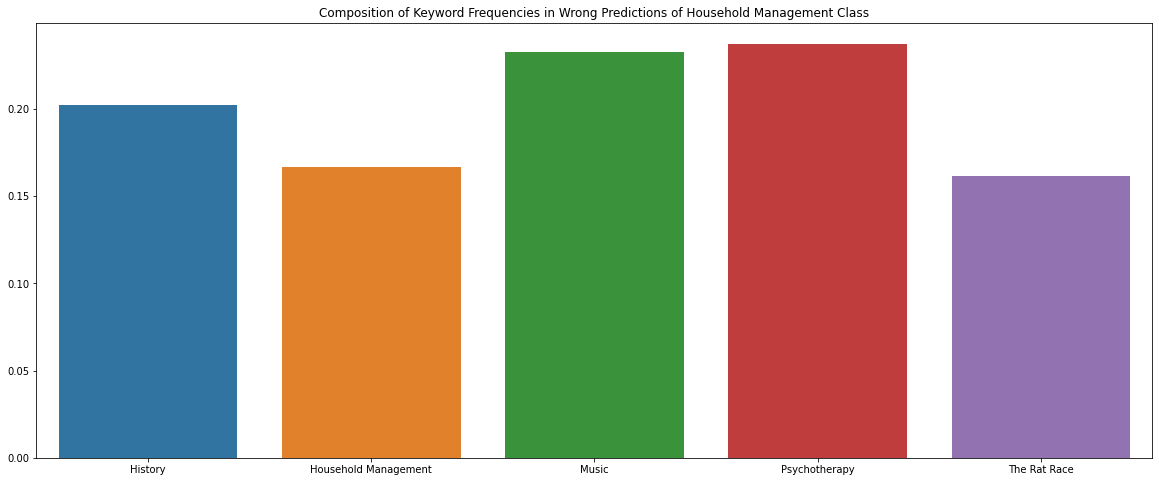

In [ ]:
kw_wrong_composition = get_keyword_ratios(wrong_df, "book_name", "Household Management", keywords_dict)
visualize_keywords(kw_wrong_composition, "Composition of Keyword Frequencies in Wrong Predictions of Household Management Class")

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



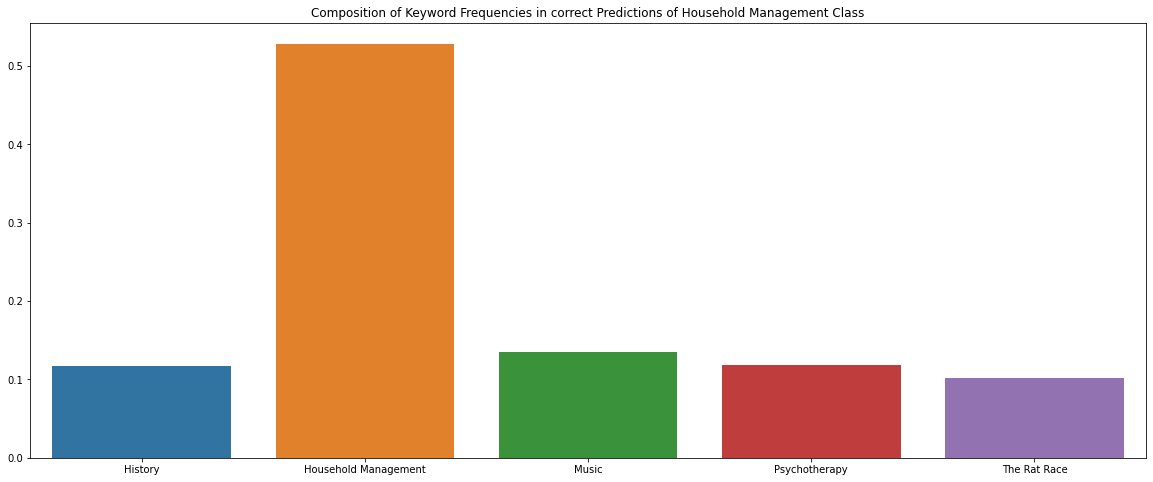

In [ ]:
kw_correct_composition = get_keyword_ratios(correct_df, "book_name", "Household Management", keywords_dict)
visualize_keywords(kw_correct_composition, "Composition of Keyword Frequencies in correct Predictions of Household Management Class")

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



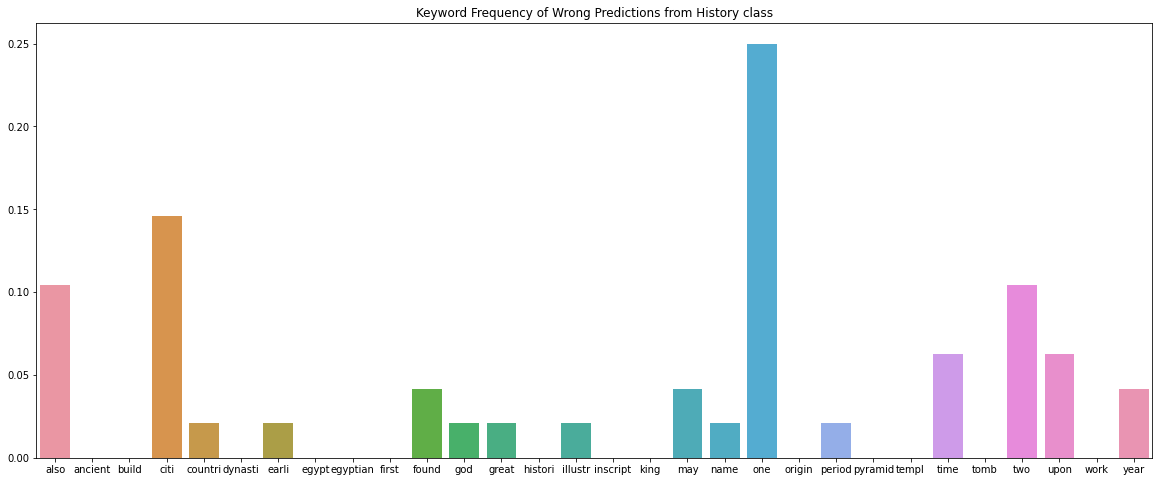

In [ ]:
wrong_words = get_keyword_ratios_single_class(wrong_df, "book_name", "History", keywords_dict["History"])
visualize_keywords(wrong_words, "Keyword Frequency of Wrong Predictions from History class")

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



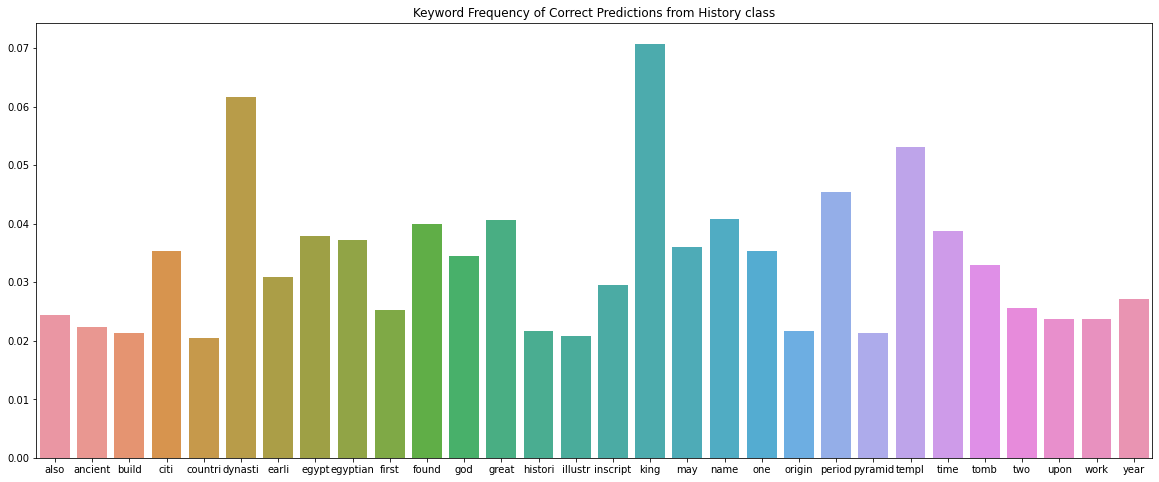

In [ ]:
correct_words = get_keyword_ratios_single_class(correct_df, "book_name", "History", keywords_dict["History"])
visualize_keywords(correct_words, "Keyword Frequency of Correct Predictions from History class")

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



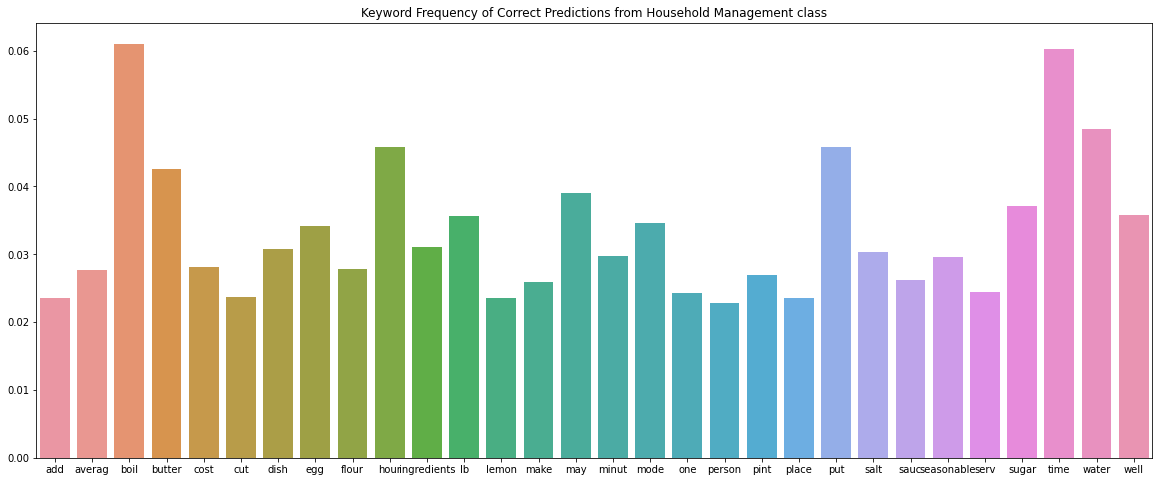

In [ ]:
correct_words = get_keyword_ratios_single_class(correct_df, "book_name", "Household Management", keywords_dict["Household Management"])
visualize_keywords(correct_words, "Keyword Frequency of Correct Predictions from Household Management class")

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



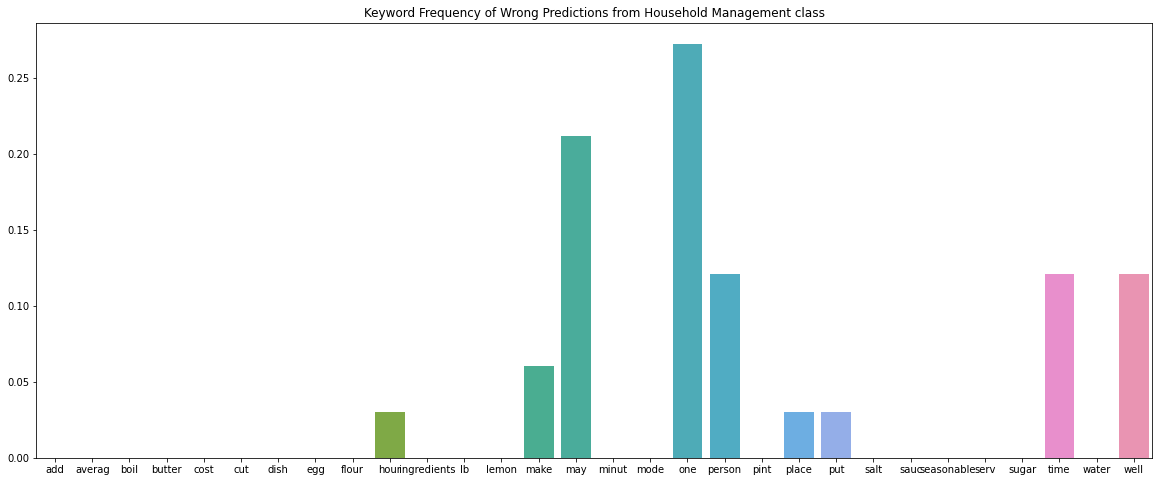

In [ ]:
wrong_words = get_keyword_ratios_single_class(wrong_df, "book_name", "Household Management", keywords_dict["Household Management"])
visualize_keywords(wrong_words, "Keyword Frequency of Wrong Predictions from Household Management class")

In [ ]:
def getSomeBooksDF(dframe,books , bookname_col = 'book_name' , cluster_col = 'cluster_book'):
  filter_book = dframe[bookname_col].apply(lambda Bname : Bname in books)
  filter_cluster = dframe[cluster_col].apply(lambda Cname : Cname in books)

  return dframe[(filter_book) & (filter_cluster)]

In [ ]:
house_history_df = getSomeBooksDF(wrong_df , ['Household Management' ,  'History'] , 'book_name' ,'cluster_book' )
house_history_df

partition  ...          cluster_book
12   water rais without labour man beast   constant...  ...  Household Management
64   thoroughli soak   squar finish fill bank repea...  ...  Household Management
196  class   event death oper   doctor give owner a...  ...  Household Management
257  properti   half retain free woman use children...  ...  Household Management
626  deleg power curb sin express tribe   appeas di...  ...               History
879  acquir desert   husband creditor   case indisp...  ...               History

[6 rows x 4 columns]

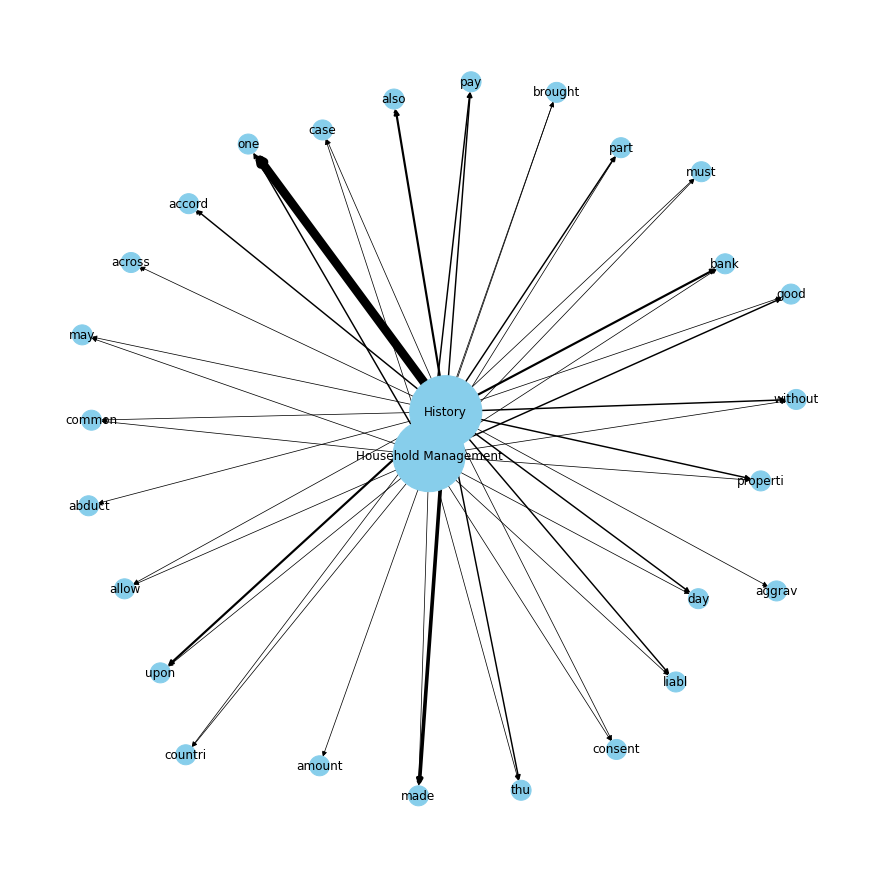

In [ ]:

knowledgeGraph(house_history_df ,
                n_top = 200 ,
                groupby = "book_name",
                no_outsumcols = 3,
                shared_only = True,
                degree_threshold = 1,
                max_width = 12,
                node_size_amplifier = 200,
                k = 2,
               is_numeric = False,
               bookName_Col_idx = -3)